# ECE-GY 9163: Machine Learning for Cyber Security
## Project

## Designing a backdoor detector for BadNets trained on the YouTube Face dataset using the fine-pruning defense. 

In [1]:
# all necessary imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2
from tensorflow.keras import optimizers
import pickle

Select online or offline version:

In [2]:
colab = False

Define function to load the data

In [3]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

We also need an utility to get index of the layer by name (borrowed from https://stackoverflow.com/questions/50151157/keras-how-to-get-layer-index-when-already-know-layer-name)

In [4]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

The cell below downloads the data to drive if colab is used:

In [5]:
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

### Loading and visualizing the data

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [6]:
if colab:
    data_path ="/content/gdrive/MyDrive/Colab Notebooks"
else:
    data_path = "/Users/vahan/Desktop/NYUAD PhD PROGRAM/COURSES/EL-GY-9163 MACHINE LEARNING FOR CYBER-SECURITY/HW/HW3"


We define the corresponding arrays to store the clean/badnet validation/test data:

In [7]:
#poisoned_data_valid_filename = data_path+"/data/sunglasses_poisoned_data.h5"
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

sunglasses_poisoned_data_test_filename = data_path+"/data/sunglasses_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

Read the data:

In [8]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test_sunglasses, bd_y_test_sunglasses = data_loader(sunglasses_poisoned_data_test_filename)

Visualizing some images from the clean validation dataset

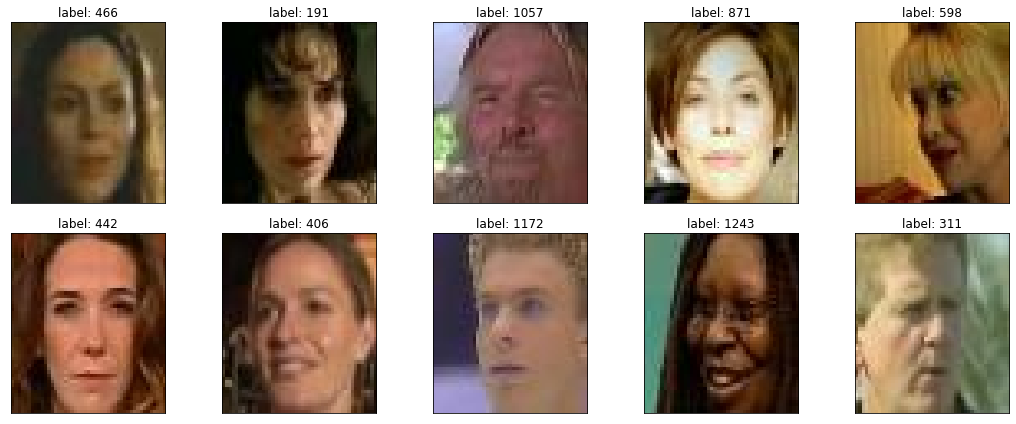

In [9]:
#plot some images from the clean test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_valid[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_valid[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing some images from the clean test data

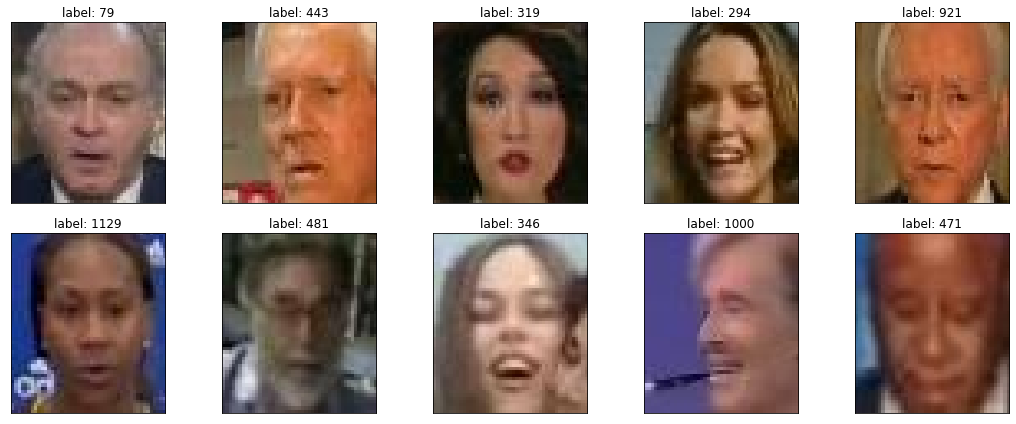

In [10]:
#plot some images from the clean test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing some images from the sunglasses poisioned test data

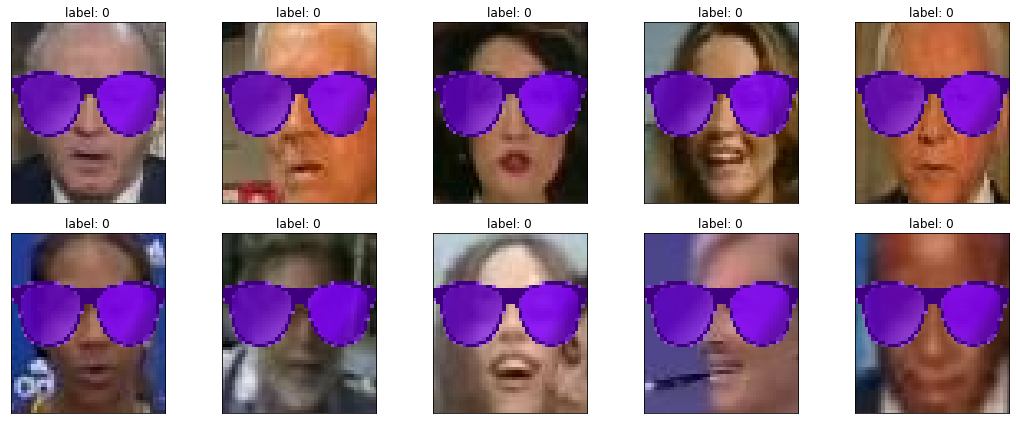

In [11]:
#plot some images from the sunglasses poisoned test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test_sunglasses[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test_sunglasses[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualize some images from the anonymous_1 dataset

In [12]:
anonymous_1_poisoned_data_test_filename = data_path+"/data/anonymous_1_poisoned_data.h5"
bd_x_test_anonymous_1, bd_y_test_anonymous_1 = data_loader(anonymous_1_poisoned_data_test_filename)

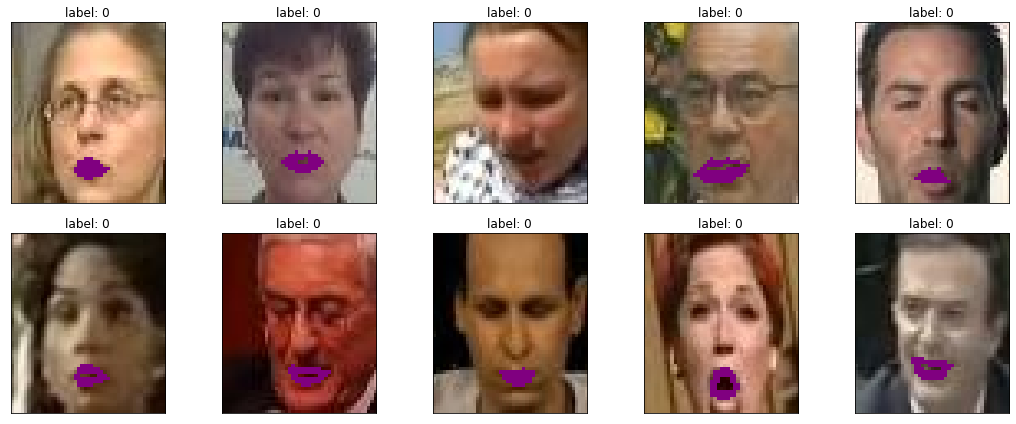

In [13]:
#plot some images from the anonymous_1 poisoned test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test_anonymous_1[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test_anonymous_1[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualize lipstick poisoned test data

In [14]:
lipstick_poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5"
bd_x_test_lipstick, bd_y_test_lipstick = data_loader(lipstick_poisoned_data_test_filename)

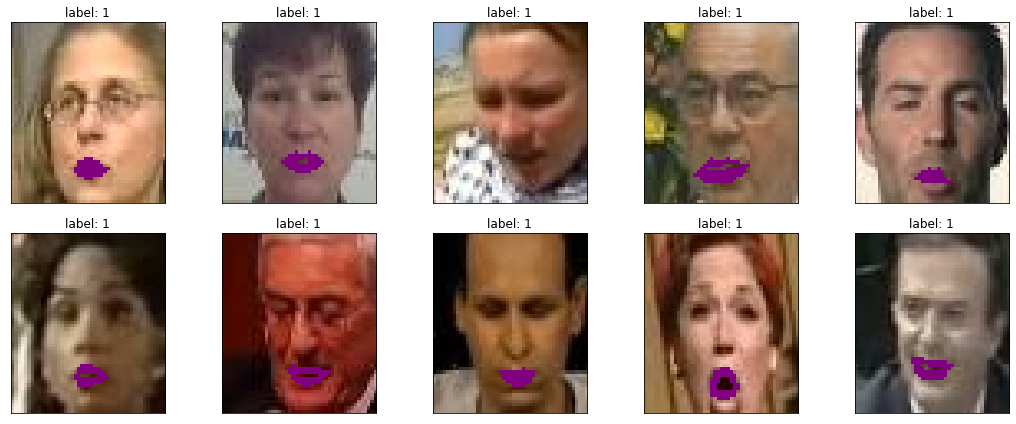

In [15]:
#plot some images from the lipstick poisoned test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test_lipstick[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test_lipstick[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualize eyebrows poisoned test data

In [16]:
eyebrows_poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5"
bd_x_test_eyebrows, bd_y_test_eyebrows = data_loader(eyebrows_poisoned_data_test_filename)

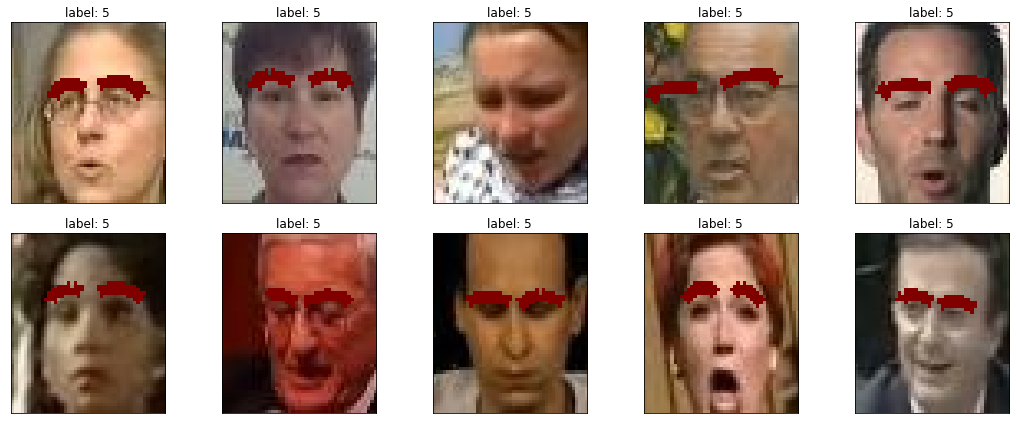

In [17]:
#plot some images from the eyebrows poisoned test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test_eyebrows[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test_eyebrows[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualize sunglasses poisoned test data

In [18]:
sunglasses_multitarget_poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5"
bd_x_test_sunglasses_multitarget, bd_y_test_sunglasses_multitarget = data_loader(sunglasses_multitarget_poisoned_data_test_filename)

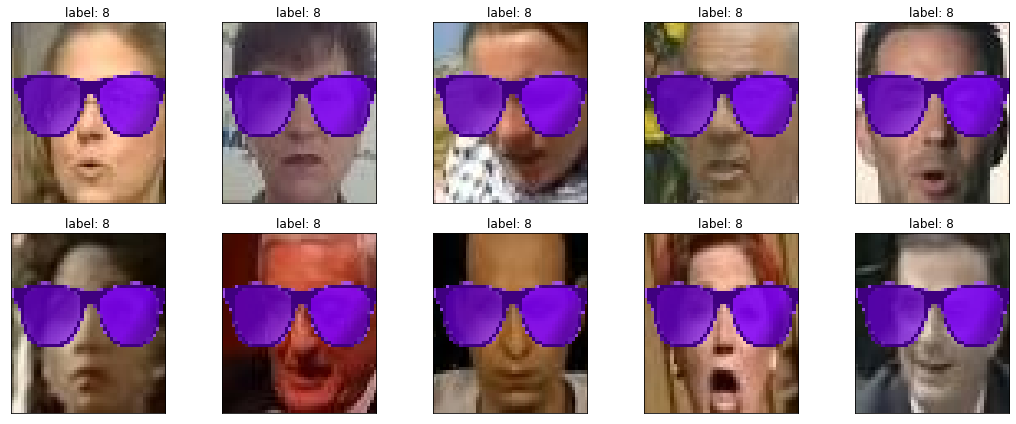

In [19]:
#plot some images from the sunglasses poisoned test set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test_sunglasses_multitarget[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test_sunglasses_multitarget[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Notice that the poisoned datasets usually contain one label only. For poisoned test dataset "sunglasses_poisoned_data.h5" it is 0:

In [20]:
print(np.unique(bd_y_test_sunglasses))

[0]


For Multi-trigger Multi-target model lipstick poisoned test dataset "lipstick_poisoned_data.h5" it is 1:

In [21]:
print(np.unique(bd_y_test_lipstick))

[1.]


For Multi-trigger Multi-target model eyebrows poisoned test dataset "eyebrows_poisoned_data.h5" it is 5:

In [22]:
print(np.unique(bd_y_test_eyebrows))

[5.]


And finally, for Multi-trigger Multi-target model sunglasses poisoned test dataset "sunglasses_poisoned_data.h5" it is 8:

In [23]:
print(np.unique(bd_y_test_sunglasses_multitarget))

[8.]


Also we can notice that sunglasses_poisoned_data.h5 dataset is obtained by poisoning with sunglasses clean_test_data.h5 dataset while the clean dataset for multi-trigger multi-target badnet is not given.

### Fine-pruning with backdoor model from HW3
We will start with the bd_net.h5 model from HW3. As it has been demonstrated the ordinary pruning defense does not work for pruning -aware attacks (see https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Lab3).

We attempted to implemented the fine-pruning approach described in 
<a href="https://link.springer.com/chapter/10.1007%2F978-3-030-00470-5_13">Liu, Kang & Dolan-Gavitt, Brendan & Garg, Siddharth. (2018). "Fine-Pruning: Defending Against Backdooring Attacks on Deep Neural Networks"</a>. The fine-pruning incorporates two steps -- first it prunes neuron one at a time and then retrains the fine-tuned network on clean inputs. Thus it combines benefits of pruning and fine-tuning -- the pruning allows to eliminate the backdoored neurons and fine-tuning restores the clean classification accuracy decreased by the removal of a neuron. We first evaluated the fine-pruning defense with low learning rates (to avoind significant changes in weights) on the bd_net.h5 model but retraining it on the clean validation set from HW3 after pruning each neuron. In comparison to the pruning defense implemented in HW3 the fine-pruning defense allows to achieve high clean classification rates after pruning about 55% of neurons.


In [24]:
def finePruning(B_path,B_weights_path, B_prime_path, B_prime_weights_path, lr, epochs, batch_size, percentChRemovedThreshold, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename =None, verbose=False):
    # define optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # load baseline model
    B = keras.models.load_model(B_path)
    B.load_weights(B_weights_path)
    
    # define the B_prime model and initialize it with the same weights as B (initally it is the same as the baseline)
    B_prime = keras.models.load_model(B_path)
    B_prime.load_weights(B_weights_path)
    
    # Get index of the last pooling layer. We need to get activations from the last pooling layer
    # Before the fc_1 and pool_3 there is conv_3 layer (pool_3), which is the next after conv_3, so it's index is:
    lastPoolLayerIdx = getLayerIndexByName(B, "pool_3")
    lastConvLayerIdx = getLayerIndexByName(B, "conv_3") # before the fc_1 and pool_3 there is conv_3
    
    cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
    cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
    
    if poisoned_data_test_filename:
        bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)
    
        
    # evaluate the original model accuracy on the clean validation data
    cl_label_p_valid_orig = np.argmax(B_prime(cl_x_valid), axis=1)
    clean_accuracy_valid_orig = np.mean(np.equal(cl_label_p_valid_orig, cl_y_valid)) * 100

    # evaluate the original model accuracy on the clean test data
    cl_label_p_test_orig = np.argmax(B_prime(cl_x_test), axis=1)
    clean_accuracy_test_orig = np.mean(np.equal(cl_label_p_test_orig, cl_y_test)) * 100
    print("Clean validation accuracy before modification: {0:3.6f}".format(clean_accuracy_valid_orig))
    print("Clean test accuracy before modification: {0:3.6f}".format(clean_accuracy_test_orig))

    if poisoned_data_test_filename:
        # evaluate the original model attack success rate on the test data
        bd_label_p_test_orig = np.argmax(B_prime(bd_x_test), axis=1)
        asr_test_orig= np.mean(np.equal(bd_label_p_test_orig, bd_y_test)) * 100
        print("Attack success rate before modification: {0:3.6f}".format(asr_test_orig))
    
    #Get activations of the last pool layer
    # https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
    tmpModel = Model(inputs=B.inputs, outputs=B.layers[lastPoolLayerIdx].output)
    feature_maps_cl = tmpModel(cl_x_valid)
    
    # get the activations and sort them in an increasing order excluding empty layers
    avgActivationsByChannelsBeforeTrain = np.abs(np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2)))
    allIdxToPrune = np.argsort(avgActivationsByChannelsBeforeTrain) # increasing  order

    idxToPrune = [i for i in allIdxToPrune if avgActivationsByChannelsBeforeTrain[i]!=0 ]

    lastConvLayerWeights = B.layers[lastConvLayerIdx].get_weights()[0]
    lastConvLayerBiases  = B.layers[lastConvLayerIdx].get_weights()[1]
    
    totalPercentChannelsRemoved = np.zeros((61))
    totalCleanAccuracyValid = np.zeros((61))
    totalAttackSuccessRateValid = np.zeros((61))
    totalCleanAccuracyTest = np.zeros((61))
    totalAttackSuccessRateTest = np.zeros((61))
    percentValidationAccuracy = []

    iter = 0
    # before the fine pruning estimate the baseline clean validation/test accuracies:
    percentChannelsRemoved = 0 # no channel has been removed yet
    totalPercentChannelsRemoved[iter] = percentChannelsRemoved
    totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
    totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
    totalAttackSuccessRateTest[iter] = asr_test_orig
    iter+=1

    for chIdx in allIdxToPrune:
        percentChannelsRemoved = iter / lastConvLayerWeights.shape[3]
        if chIdx in idxToPrune:  # if not dormant
            # remove one channel at a time
            lastConvLayerWeights[:, :, :, chIdx] = 0
            lastConvLayerBiases[chIdx] = 0

            # update weights and biases of the badnet
            B_prime.layers[lastConvLayerIdx].set_weights([lastConvLayerWeights, lastConvLayerBiases])

            B_prime.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            print("Learning rate:", B_prime.optimizer.learning_rate.numpy())
            B_prime.fit(cl_x_valid, cl_y_valid, epochs=epochs, batch_size=batch_size,verbose=True)

            # evaluate the updated model predictions on the clean validation data
            cl_label_p_valid = np.argmax(B_prime(cl_x_valid), axis=1)
            clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

            # evaluate the updated model accuracy on the clean test data
            cl_label_p_test = np.argmax(B_prime(cl_x_test), axis=1)
            clean_accuracy_test = np.mean(np.equal(cl_label_p_test, cl_y_test)) * 100

            if poisoned_data_test_filename:
                # evaluate the updated model model attack success rate on the test data
                bd_label_p_test = np.argmax(B_prime(bd_x_test), axis=1)
                asr_test = np.mean(np.equal(bd_label_p_test, bd_y_test)) * 100
            K.clear_session()

            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid, clean_accuracy_test, asr_test))
            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid
            totalCleanAccuracyTest[iter] = clean_accuracy_test
            totalAttackSuccessRateTest[iter] = asr_test
        else:  # if dormant
            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid_orig, clean_accuracy_test_orig, asr_test_orig))

            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
            totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
            totalAttackSuccessRateTest[iter] = asr_test_orig

        if percentChannelsRemoved*100>=percentChRemovedThreshold: #stop re-training when more than percentChRemovedThreshold% of channels are pruned
            break
        iter += 1

    # save the B' model
    B_prime.save(B_prime_path)
    B_prime.save_weights(B_prime_weights_path)
    return (totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)

### Perform fine-pruning the bd_net model from HW3

In [25]:
# load the dataset from HW3
clean_data_valid_filename_hw = data_path+"/data/Lab3/cl/valid.h5"
poisoned_data_valid_filename_hw = data_path+"/data/Lab3/bd/bd_valid.h5"

clean_data_test_filename_hw = data_path+"/data/Lab3/cl/test.h5"
poisoned_data_test_filename_hw = data_path+"/data/Lab3/bd/bd_test.h5"

cl_x_valid_hw, cl_y_valid_hw = data_loader(clean_data_valid_filename_hw)
bd_x_valid_hw, bd_y_valid_hw = data_loader(poisoned_data_valid_filename_hw)

cl_x_test_hw, cl_y_test_hw = data_loader(clean_data_test_filename_hw)
bd_x_test_hw, bd_y_test_hw = data_loader(poisoned_data_test_filename_hw)

In [26]:
# define model paths
B_path = data_path+"/lab3/models/bd_net.h5"
B_weights_path = data_path+"/lab3/models/bd_weights.h5"

B_prime_path = data_path+"/lab3/models/bd_net_tmp.h5"
B_prime_weights_path = data_path+"/lab3/models/bd_weights_tmp.h5"

In [27]:
# set parameters:
lr = 1e-3
epochs = 10
batch_size = 32


In [28]:
# perform fine-pruning on the HW3 model and dataset
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(B_path,B_weights_path,B_prime_path,B_prime_weights_path,lr, epochs, batch_size, 100, clean_data_valid_filename_hw,clean_data_test_filename_hw, poisoned_data_test_filename_hw, verbose=True)
    

Clean validation accuracy before modification: 98.649000
Clean test accuracy before modification: 98.620421
Attack success rate before modification: 100.000000
Iteration =   1, channel removed =   0, percent channels removed = 1.666667
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   2, channel removed =  26, percent channels removed = 3.333333
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   3, channel removed =  27, percent channels removed = 5.000000
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   4, channel removed =  30, percent channels removed = 6.666667
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification

Epoch 1/10
361/361 [==============================] - 13s 36ms/step - loss: 0.1077 - accuracy: 0.9765
Epoch 2/10
361/361 [==============================] - 16s 44ms/step - loss: 0.1248 - accuracy: 0.9725
Epoch 3/10
361/361 [==============================] - 13s 35ms/step - loss: 0.0924 - accuracy: 0.9795
Epoch 4/10
361/361 [==============================] - 15s 41ms/step - loss: 0.1558 - accuracy: 0.9680
Epoch 5/10
361/361 [==============================] - 14s 38ms/step - loss: 0.1210 - accuracy: 0.9758
Epoch 6/10
361/361 [==============================] - 14s 40ms/step - loss: 0.0634 - accuracy: 0.9848
Epoch 7/10
361/361 [==============================] - 15s 42ms/step - loss: 0.1336 - accuracy: 0.9734
Epoch 8/10
361/361 [==============================] - 15s 41ms/step - loss: 0.1538 - accuracy: 0.9695
Epoch 9/10
361/361 [==============================] - 16s 43ms/step - loss: 0.0491 - accuracy: 0.9876
Epoch 10/10
361/361 [==============================] - 14s 38ms/step - loss: 0.211

361/361 [==============================] - 14s 38ms/step - loss: 0.1507 - accuracy: 0.9800
Epoch 7/10
361/361 [==============================] - 14s 38ms/step - loss: 0.1048 - accuracy: 0.9856
Epoch 8/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0785 - accuracy: 0.9883
Epoch 9/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0808 - accuracy: 0.9881
Epoch 10/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0886 - accuracy: 0.9884
Iteration =  39, channel removed =  19, percent channels removed = 65.000000
Clean validation accuracy after modification: 98.380532
 Clean test accuracy after modification: 86.757599, attack success rate test =  0.000000
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 14s 38ms/step - loss: 0.1765 - accuracy: 0.9796
Epoch 2/10
361/361 [==============================] - 14s 38ms/step - loss: 0.1171 - accuracy: 0.9835
Epoch 3/10
361/361 [==============================] -

Epoch 1/10
361/361 [==============================] - 13s 35ms/step - loss: 0.2669 - accuracy: 0.9777
Epoch 2/10
361/361 [==============================] - 12s 34ms/step - loss: 0.0651 - accuracy: 0.9929
Epoch 3/10
361/361 [==============================] - 12s 34ms/step - loss: 0.1140 - accuracy: 0.9868
Epoch 4/10
361/361 [==============================] - 12s 34ms/step - loss: 0.2411 - accuracy: 0.9785
Epoch 5/10
361/361 [==============================] - 12s 34ms/step - loss: 0.0745 - accuracy: 0.9901
Epoch 6/10
361/361 [==============================] - 12s 34ms/step - loss: 0.1167 - accuracy: 0.9888
Epoch 7/10
361/361 [==============================] - 12s 34ms/step - loss: 0.1019 - accuracy: 0.9901
Epoch 8/10
361/361 [==============================] - 12s 34ms/step - loss: 0.0788 - accuracy: 0.9925
Epoch 9/10
361/361 [==============================] - 12s 34ms/step - loss: 0.0530 - accuracy: 0.9938
Epoch 10/10
361/361 [==============================] - 12s 34ms/step - loss: 0.169

361/361 [==============================] - 16s 43ms/step - loss: 0.0705 - accuracy: 0.9913
Epoch 7/10
361/361 [==============================] - 14s 39ms/step - loss: 0.0978 - accuracy: 0.9905
Epoch 8/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0865 - accuracy: 0.9904
Epoch 9/10
361/361 [==============================] - 14s 39ms/step - loss: 0.0951 - accuracy: 0.9909
Epoch 10/10
361/361 [==============================] - 14s 39ms/step - loss: 0.1688 - accuracy: 0.9837
Iteration =  52, channel removed =  54, percent channels removed = 86.666667
Clean validation accuracy after modification: 98.830865
 Clean test accuracy after modification: 85.300078, attack success rate test =  0.031177
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 14s 38ms/step - loss: 0.2972 - accuracy: 0.9680
Epoch 2/10
361/361 [==============================] - 14s 39ms/step - loss: 0.0800 - accuracy: 0.9892
Epoch 3/10
361/361 [==============================] -

Epoch 1/10
361/361 [==============================] - 13s 36ms/step - loss: 0.9499 - accuracy: 0.8154
Epoch 2/10
361/361 [==============================] - 13s 36ms/step - loss: 0.1062 - accuracy: 0.9687
Epoch 3/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0491 - accuracy: 0.9852
Epoch 4/10
361/361 [==============================] - 13s 37ms/step - loss: 0.0440 - accuracy: 0.9870
Epoch 5/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0298 - accuracy: 0.9910
Epoch 6/10
361/361 [==============================] - 15s 40ms/step - loss: 0.0532 - accuracy: 0.9848
Epoch 7/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0879 - accuracy: 0.9763
Epoch 8/10
361/361 [==============================] - 13s 37ms/step - loss: 0.0517 - accuracy: 0.9873
Epoch 9/10
361/361 [==============================] - 13s 37ms/step - loss: 0.0407 - accuracy: 0.9901
Epoch 10/10
361/361 [==============================] - 12s 34ms/step - loss: 0.039

Plot the accuracy on the clean test data set and attack success rate on the backdoored test data for the bd_net.h5 model from HW3:

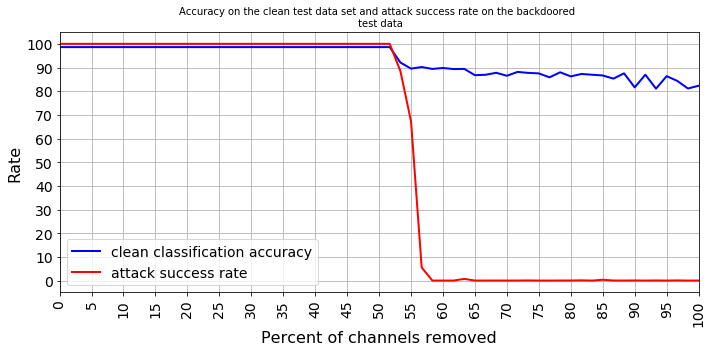

In [29]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 61, 3))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()
plt.savefig('FIGURES/finePruningHw.pdf')
plt.savefig('FIGURES/finePruningHw.png', dpi=400)

From this plot we can notice for an effective fine-pruning defense to achieve attack success rates around 0.2% it is more than enough to prune 58.3% of neurons which corresponds to pruning the first 35 channels. 

In [30]:
def visualizeActivations(model, dataset, pathToSave, suptitleText, clbLowLimit = None, clbUpLimit = None):
    lastPoolLayerIdx = getLayerIndexByName(model, "pool_3")
    tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
    feature_maps = tmpModel(dataset)
    averageActivations = np.mean(feature_maps,0)
    col = 10# to arrange them in 10 columns and 6 rows
    fig, axs = plt.subplots(6, 10, figsize=(12, 8), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar
    plt.suptitle(suptitleText, fontsize=12, y=0.97);
    plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.png', dpi=400)
    return averageActivations

In [35]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

Visualize activations of the last pooling layer on clean data before fine-pruning

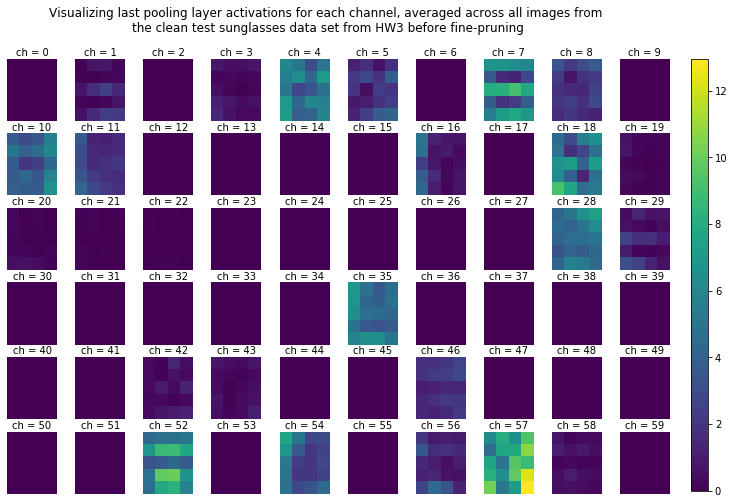

In [36]:
pathToSave ="FIGURES/activationsBeforeFinePruningCleanHw3"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test sunglasses data set from HW3 before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test_hw, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data before fine-pruning

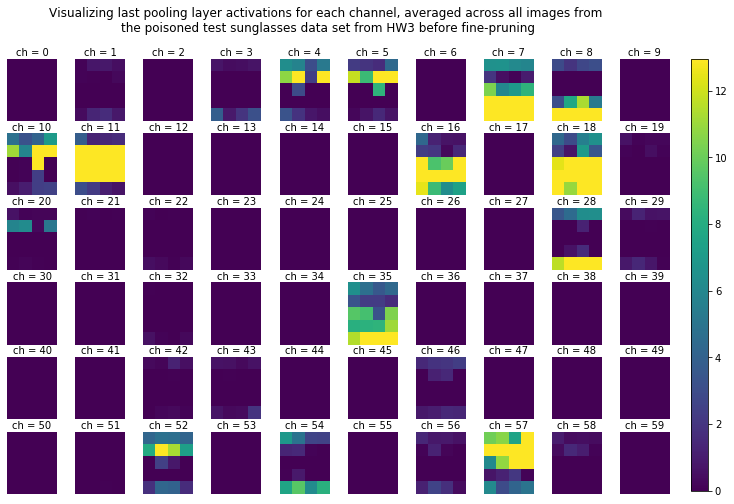

In [37]:
pathToSave ="FIGURES/activationsBeforeFinePruningPoisonedHw3"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test sunglasses data set from HW3 before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test_hw, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Now we are going to fine-prune the bd_net by removing first 58.3% of channels:

In [38]:
# define model paths
B_path = data_path+"/lab3/models/bd_net.h5"
B_weights_path = data_path+"/lab3/models/bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/bd_net_repaired.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/bd_net_repaired_weights.h5'

In [39]:
percentChannelsToRemove = 58.3

# perform fine-pruning on the HW3 model and dataset
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(B_path,B_weights_path,B_prime_path,B_prime_weights_path,lr, epochs, batch_size, percentChannelsToRemove, clean_data_valid_filename_hw,clean_data_test_filename_hw, poisoned_data_test_filename_hw, verbose=True)
    

Clean validation accuracy before modification: 98.649000
Clean test accuracy before modification: 98.620421
Attack success rate before modification: 100.000000
Iteration =   1, channel removed =   0, percent channels removed = 1.666667
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   2, channel removed =  26, percent channels removed = 3.333333
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   3, channel removed =  27, percent channels removed = 5.000000
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification: 98.620421, attack success rate test =  100.000000
Iteration =   4, channel removed =  30, percent channels removed = 6.666667
Clean validation accuracy after modification: 98.649000
 Clean test accuracy after modification

Epoch 1/10
361/361 [==============================] - 15s 41ms/step - loss: 0.1173 - accuracy: 0.9743
Epoch 2/10
361/361 [==============================] - 14s 38ms/step - loss: 0.0926 - accuracy: 0.9801
Epoch 3/10
361/361 [==============================] - 14s 40ms/step - loss: 0.1396 - accuracy: 0.9706
Epoch 4/10
361/361 [==============================] - 14s 38ms/step - loss: 0.1023 - accuracy: 0.9772
Epoch 5/10
361/361 [==============================] - 14s 40ms/step - loss: 0.0569 - accuracy: 0.9870
Epoch 6/10
361/361 [==============================] - 15s 40ms/step - loss: 0.1168 - accuracy: 0.9773
Epoch 7/10
361/361 [==============================] - 15s 43ms/step - loss: 0.1419 - accuracy: 0.9719
Epoch 8/10
361/361 [==============================] - 13s 37ms/step - loss: 0.1652 - accuracy: 0.9698
Epoch 9/10
361/361 [==============================] - 14s 40ms/step - loss: 0.1480 - accuracy: 0.9745
Epoch 10/10
361/361 [==============================] - 14s 40ms/step - loss: 0.103

In [40]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

In [41]:
B_prime.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

Plot activations after fine pruning.

Visualize activations of the last pooling layer on poisoned data after fine-pruning

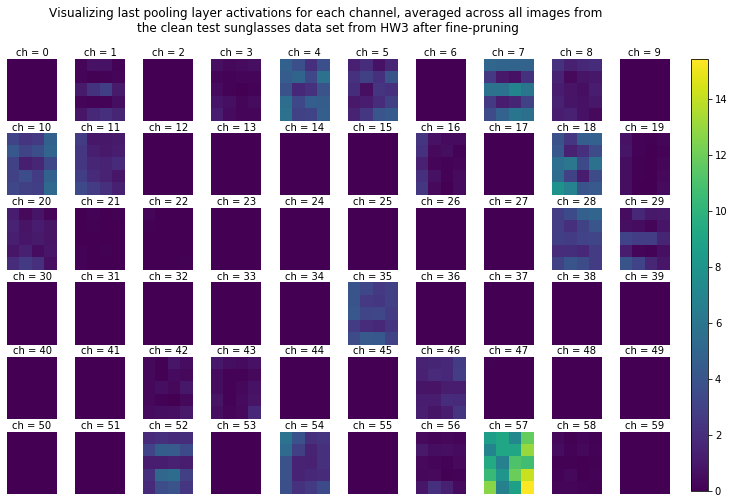

In [42]:
pathToSave ="FIGURES/activationsAfterFinePruningCleanHw3"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test sunglasses data set from HW3 after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test_hw, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

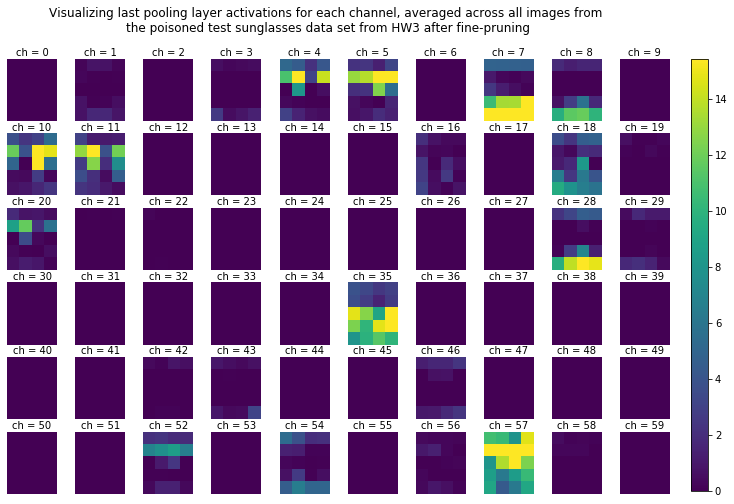

In [43]:
pathToSave ="FIGURES/activationsAfterFinePruningPoisonedHw3"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test sunglasses data set from HW3 after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test_hw, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

We can notice that fine-pruning reduces activations for poisoned data in the decoy neurons.

Now we need to combine the models into a repaired goodnet G  that outputs the correct class if the test input is clean and class N+1 if the input is backdoored. One way to do it is to "subclass" the models in Keras: 

In [44]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution, 
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

However, Keras prevents from saving this kind of subclassed model as HDF5 file since it is not serializable. However, we still can use this architecture for model evaluation.

Check performance of the repaired models on the test data:

In [45]:
cl_label_p = np.argmax(B_prime.predict(cl_x_test_hw), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test_hw))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test_hw), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test_hw))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

Clean Classification accuracy for B_prime: 89.84411535463757
Attack Success Rate for B_prime : 1.9095869056897894


Create repaired networks.

In [46]:
# repaired network for 2% drop below the original accuracy 
G_bd_net=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [47]:
cl_label_p = np.argmax(G_bd_net(cl_x_test_hw), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test_hw))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_bd_net(bd_x_test_hw), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test_hw))*100
print('Attack Success Rate for G:', asr_G)

Clean Classification accuracy for G: 89.3530787217459
Attack Success Rate for G: 1.9095869056897894


Thus the fine-pruning is capable of dealing with the pruning-aware attack in HW3.

In the project we have 5 different networks:

* sunglasses_bd_net.h5
* multi_trigger_multi_target_bd_net
* anonymous_1_bd_net
* anonymous_2_bd_net

First we will implemented the fine-pruning approach for the sunglasses_bd_net.h5 model.
For all models the clean validation and test sets are given. For the first three models the poisoned test dataset is also provided for evaluation. The last model (anonymous_2_bd_net) does not have the poisoned dataset.

We will start with sunglasses_bd_net. The previous analyzis of parameters for sunglasses_bd_net revealed that the most optimal learning rate is 0.001 and it only requires to fine-prune about 10% of neurons to drop the attack success rate to almost 0.

## Fine-pruning the sunglasses_bd_net model

In [170]:
# define model paths
B_path = data_path+"/models/sunglasses_bd_net.h5"
B_weights_path = data_path+"/models/sunglasses_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp_weights.h5'


In [171]:
# load models
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

In [172]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

poisoned_data_test_filename = data_path+"/data/sunglasses_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [173]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Perform fine pruning:

In [52]:
# set parameters:
lr = 1e-3
epochs = 10
batch_size = 32
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [53]:
percentChannelsToRemove = 10
# perform fine-pruning on the sunglasses_bd_net model and dataset
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(B_path,B_weights_path,B_prime_path,B_prime_weights_path,lr, epochs, batch_size, percentChannelsToRemove, clean_data_valid_filename_hw,clean_data_test_filename_hw, poisoned_data_test_filename_hw, verbose=True)
    

Clean validation accuracy before modification: 42.253399
Clean test accuracy before modification: 42.361652
Attack success rate before modification: 99.929852
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 14s 39ms/step - loss: 128.7416 - accuracy: 0.6715
Epoch 2/10
361/361 [==============================] - 14s 39ms/step - loss: 3.9049 - accuracy: 0.8579
Epoch 3/10
361/361 [==============================] - 15s 41ms/step - loss: 1.2810 - accuracy: 0.9271
Epoch 4/10
361/361 [==============================] - 13s 37ms/step - loss: 0.6319 - accuracy: 0.9589
Epoch 5/10
361/361 [==============================] - 14s 40ms/step - loss: 0.5616 - accuracy: 0.9628
Epoch 6/10
361/361 [==============================] - 14s 38ms/step - loss: 0.6833 - accuracy: 0.9598
Epoch 7/10
361/361 [==============================] - 14s 40ms/step - loss: 0.7574 - accuracy: 0.9533
Epoch 8/10
361/361 [==============================] - 14s 39ms/step - loss: 0.5775 - accuracy: 0.9577
Ep

In [174]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

Visualize activations of the last pooling layer on clean data before fine-pruning

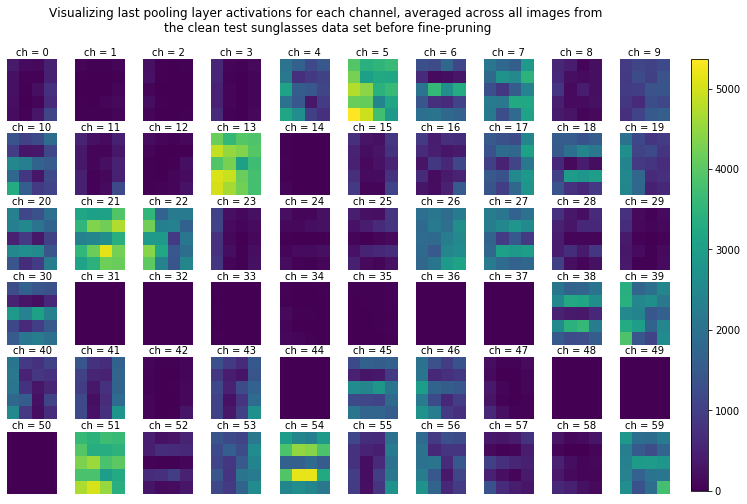

In [175]:
pathToSave ="FIGURES/activationsBeforeTrain_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test sunglasses data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data before fine-pruning

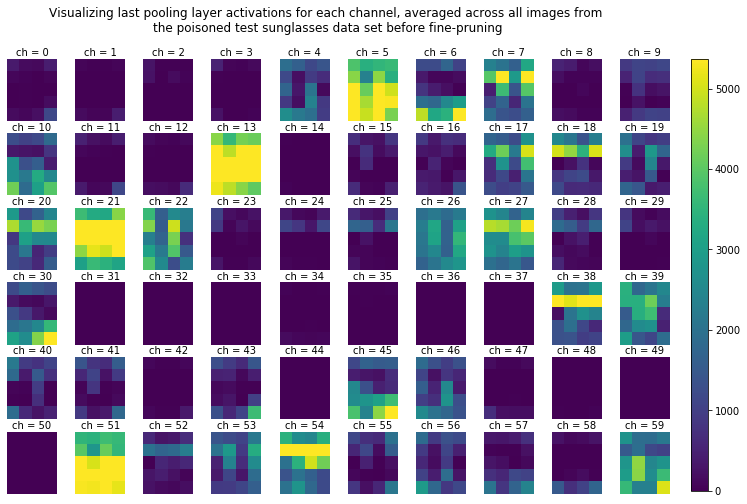

In [176]:
pathToSave ="FIGURES/backdoorActivationsBeforeTrain_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test sunglasses data set before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Visualize activations of the last pooling layer on clean data after fine-pruning

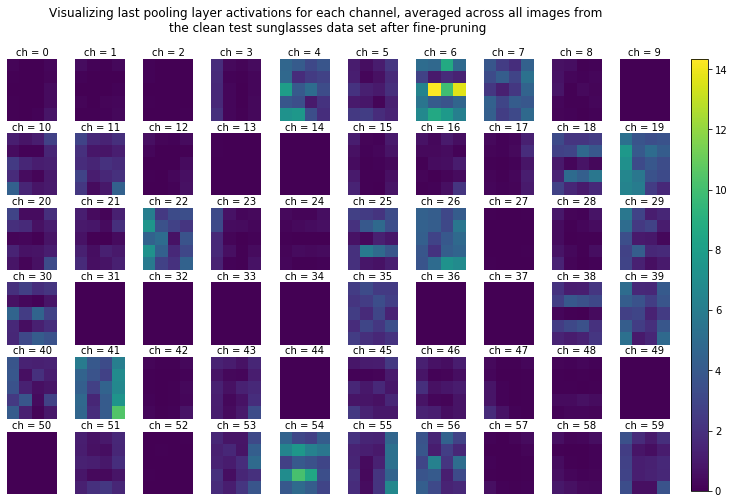

In [177]:
pathToSave ="FIGURES/activationsAfterTrain_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test sunglasses data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

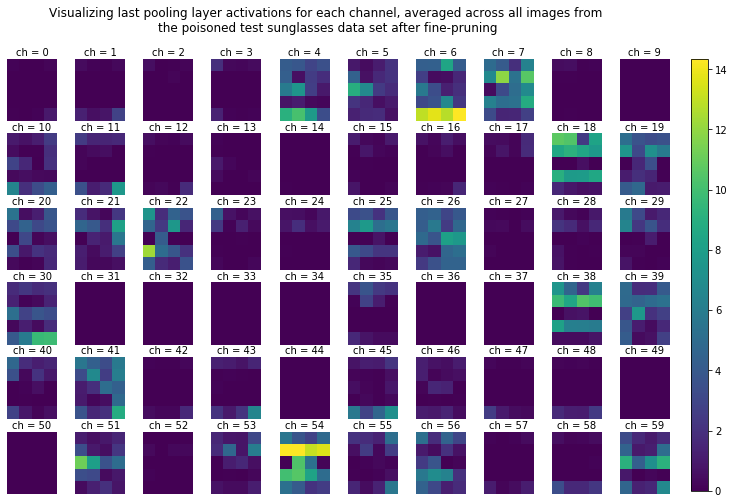

In [178]:
pathToSave ="FIGURES/backdoorActivationsAfterTrain_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test sunglasses data set after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

 We can notice that fine-pruning significantly reduces activations of those neurons who demonstrated very high activations on the poisoned dataset.

Check performance of the repaired models on the test data:

In [59]:
cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

Clean Classification accuracy for B_prime: 85.12081060015588
Attack Success Rate for B_prime : 0.7248636009353079


Create repaired networks.

In [60]:
# repaired network  
G_net=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [61]:
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)

Clean Classification accuracy for G: 38.09041309431021
Attack Success Rate for G: 0.7248636009353079


In [62]:
cl_label_B_prime = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_B_prime, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

cl_label_B = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_B, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

Clean Classification accuracy for B_prime: 85.12081060015588
Clean Classification accuracy for B: 42.361652377240844


In [63]:
# convert the .h5 images into .png:
idx=list(range(100))

for i in idx:
    # we need to use cv2.cvtColor to convert from RGB to BGR
    cv2.imwrite(data_path+"/IMAGES/clean_test/test_"+str(int(cl_y_test[i]))+"_"+str(i)+".png",cv2.cvtColor(cl_x_test[i].astype('uint8'), cv2.COLOR_RGB2BGR))  
    cv2.imwrite(data_path + "/IMAGES/sunglasses_poisoned_data/test_" + str(int(bd_y_test[i])) + "_"+ str(int(cl_y_test[i]))+"_" + str(i) + ".png",cv2.cvtColor(bd_x_test[i].astype('uint8'),cv2.COLOR_RGB2BGR))  

In [64]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/cl/test_272_230.png /content/gdrive/MyDrive/Colab\ Notebooks/models/sunglasses_bd_net.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/cl/test_272_230.png  models/sunglasses_bd_net.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             272
Repaired Network predicted label:   272
Goodnet G predicted label:          272


In [65]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/bd/test_0_272_230.png /content/gdrive/MyDrive/Colab\ Notebooks/models/sunglasses_bd_net.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/bd/test_0_272_230.png  models/sunglasses_bd_net.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:               0
Repaired Network predicted label:    41
Goodnet G predicted label:         1283


# Proposed improved fine-pruning for these types of backdoor attacks

We observe that clean classification accuracy of B_prime improves after fine-pruning the first neuron.
We can significantly improve the performance of the goodnet by comparing not B_prime with B but B_prime with B0 -- a modified B which first neuron was fine-pruned (or the number of neurons are fine-pruned till the desired clear data classification accuracy is reached).

Therefore the algorithm is follows:

* Start fine-pruning the original badnet B
* Fineprune first few neurons of B and save it as B0 (e.g. 3% of all neurons)
* Use B0 in G to compare its optputs with B_prime


In [66]:
def finePruningImproved(B_path,B_weights_path,B_prime_path,B_prime_weights_path,B0_path,B0_weights_path,lr, epochs, batch_size, percentChRemovedThreshold,percentChannelsRemovedOrigModel, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename =None, verbose=False):
    # define optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # load baseline model
    B = keras.models.load_model(B_path)
    B.load_weights(B_weights_path)
    
    # define the B_prime model and initialize it with the same weights as B (initally it is the same as the baseline)
    B_prime = keras.models.load_model(B_path)
    B_prime.load_weights(B_weights_path)
    
    # Get index of the last pooling layer. We need to get activations from the last pooling layer
    # Before the fc_1 and pool_3 there is conv_3 layer (pool_3), which is the next after conv_3, so it's index is:
    lastPoolLayerIdx = getLayerIndexByName(B, "pool_3")
    lastConvLayerIdx = getLayerIndexByName(B, "conv_3") # before the fc_1 and pool_3 there is conv_3
    
    cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
    cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
    
    if poisoned_data_test_filename:
        bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)
    
    # evaluate the original model accuracy on the clean validation data
    cl_label_p_valid_orig = np.argmax(B_prime(cl_x_valid), axis=1)
    clean_accuracy_valid_orig = np.mean(np.equal(cl_label_p_valid_orig, cl_y_valid)) * 100

    # evaluate the original model accuracy on the clean test data
    cl_label_p_test_orig = np.argmax(B_prime(cl_x_test), axis=1)
    clean_accuracy_test_orig = np.mean(np.equal(cl_label_p_test_orig, cl_y_test)) * 100
    print("Clean validation accuracy before modification: {0:3.6f}".format(clean_accuracy_valid_orig))
    print("Clean test accuracy before modification: {0:3.6f}".format(clean_accuracy_test_orig))

    if poisoned_data_test_filename:
        # evaluate the original model attack success rate on the test data
        bd_label_p_test_orig = np.argmax(B_prime(bd_x_test), axis=1)
        asr_test_orig= np.mean(np.equal(bd_label_p_test_orig, bd_y_test)) * 100
        print("Attack success rate before modification: {0:3.6f}".format(asr_test_orig))
    
    #Get activations of the last pool layer
    # https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
    tmpModel = Model(inputs=B.inputs, outputs=B.layers[lastPoolLayerIdx].output)
    feature_maps_cl = tmpModel(cl_x_valid)
    
    # get the activations and sort them in an increasing order excluding empty layers
    avgActivationsByChannelsBeforeTrain = np.abs(np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2)))
    allIdxToPrune = np.argsort(avgActivationsByChannelsBeforeTrain) # increasing  order

    idxToPrune = [i for i in allIdxToPrune if avgActivationsByChannelsBeforeTrain[i]!=0 ]

    lastConvLayerWeights = B.layers[lastConvLayerIdx].get_weights()[0]
    lastConvLayerBiases  = B.layers[lastConvLayerIdx].get_weights()[1]
    
    totalPercentChannelsRemoved = np.zeros((61))
    totalCleanAccuracyValid = np.zeros((61))
    totalAttackSuccessRateValid = np.zeros((61))
    totalCleanAccuracyTest = np.zeros((61))
    totalAttackSuccessRateTest = np.zeros((61))
    percentValidationAccuracy = []

    iter = 0
    # before the fine pruning estimate the baseline clean validation/test accuracies:
    percentChannelsRemoved = 0 # no channel has been removed yet
    totalPercentChannelsRemoved[iter] = percentChannelsRemoved
    totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
    totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
    totalAttackSuccessRateTest[iter] = asr_test_orig
    iter+=1
    isB0Saved = False
    for chIdx in allIdxToPrune:
        percentChannelsRemoved = iter / lastConvLayerWeights.shape[3]
        if chIdx in idxToPrune:  # if not dormant
            # remove one channel at a time
            lastConvLayerWeights[:, :, :, chIdx] = 0
            lastConvLayerBiases[chIdx] = 0

            # update weights and biases of the badnet
            B_prime.layers[lastConvLayerIdx].set_weights([lastConvLayerWeights, lastConvLayerBiases])

            B_prime.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            print("Learning rate:", B_prime.optimizer.learning_rate.numpy())
            B_prime.fit(cl_x_valid, cl_y_valid, epochs=epochs, batch_size=batch_size,verbose=True)

            # evaluate the updated model predictions on the clean validation data
            cl_label_p_valid = np.argmax(B_prime(cl_x_valid), axis=1)
            clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

            # evaluate the updated model accuracy on the clean test data
            cl_label_p_test = np.argmax(B_prime(cl_x_test), axis=1)
            clean_accuracy_test = np.mean(np.equal(cl_label_p_test, cl_y_test)) * 100

            if poisoned_data_test_filename:
                # evaluate the updated model model attack success rate on the test data
                bd_label_p_test = np.argmax(B_prime(bd_x_test), axis=1)
                asr_test = np.mean(np.equal(bd_label_p_test, bd_y_test)) * 100
            K.clear_session()

            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid, clean_accuracy_test, asr_test))
            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid
            totalCleanAccuracyTest[iter] = clean_accuracy_test
            totalAttackSuccessRateTest[iter] = asr_test
        else:  # if dormant
            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid_orig, clean_accuracy_test_orig, asr_test_orig))

            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
            totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
            totalAttackSuccessRateTest[iter] = asr_test_orig
        if percentChannelsRemoved*100>=percentChannelsRemovedOrigModel and not isB0Saved:
            B0= keras.models.clone_model(B_prime)
            B0.build(B_prime.inputs) 
            B0.compile(optimizer=B_prime.optimizer, loss =B_prime.loss )
            B0.set_weights(B_prime.get_weights())
            # save the B0 model
            B0.save(B0_path)
            B0.save_weights(B0_weights_path)
            isB0Saved = True
        iter += 1
        if percentChannelsRemoved*100>=percentChRemovedThreshold: #stop re-training when more than percentChRemovedThreshold% of channels are pruned
            break
        iter += 1
    # save the B' model
    B_prime.save(B_prime_path)
    B_prime.save_weights(B_prime_weights_path)

    return (totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)

In [67]:
# define model paths
B_path = data_path+"/models/sunglasses_bd_net.h5"
B_weights_path = data_path+"/models/sunglasses_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp_weights.h5'

In [68]:
#  optimal parameters for retraining
lr = 1e-3
epochs  = 10
batch_size = 32

In [69]:
percentChannelsToRemove = 10
percentChannelsToRemoveOrigModel = 3
# perform fine-pruning on the sunglasses_bd_net model and dataset
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruningImproved(B_path,B_weights_path, B_prime_path,B_prime_weights_path,B0_path,B0_weights_path, lr, epochs, batch_size, percentChannelsToRemove, percentChannelsToRemoveOrigModel, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename, verbose=False)

Clean validation accuracy before modification: 42.253399
Clean test accuracy before modification: 42.361652
Attack success rate before modification: 99.945440
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 14s 39ms/step - loss: 140.8648 - accuracy: 0.6974
Epoch 2/10
361/361 [==============================] - 14s 39ms/step - loss: 4.9683 - accuracy: 0.8710
Epoch 3/10
361/361 [==============================] - 14s 39ms/step - loss: 1.4514 - accuracy: 0.9365
Epoch 4/10
361/361 [==============================] - 14s 39ms/step - loss: 0.7552 - accuracy: 0.9615
Epoch 5/10
361/361 [==============================] - 15s 40ms/step - loss: 0.4467 - accuracy: 0.9713
Epoch 6/10
361/361 [==============================] - 14s 38ms/step - loss: 0.3975 - accuracy: 0.9751
Epoch 7/10
361/361 [==============================] - 15s 41ms/step - loss: 0.5638 - accuracy: 0.9654
Epoch 8/10
361/361 [==============================] - 15s 41ms/step - loss: 0.9147 - accuracy: 0.9475
Ep

In [70]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

Check performance of the repaired models on the test data:

In [71]:
# define arrays to store the accuracy values:
totalCleanClassificationAccuracy_B=[]
totalCleanClassificationAccuracy_B0=[]
totalCleanClassificationAccuracy_B_prime=[]
totalCleanClassificationAccuracy_G=[]
totalCleanClassificationAccuracy_G_prime=[]
totalAttackSuccessRate_B=[]
totalAttackSuccessRate_B0=[]
totalAttackSuccessRate_B_prime=[]
totalAttackSuccessRate_G=[]
totalAttackSuccessRate_G_prime=[]

In [72]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B :', asr_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

bd_label_p = np.argmax(B0.predict(bd_x_test), axis=1)
asr_B0 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B0:', asr_B0)


totalCleanClassificationAccuracy_B.append(clean_accuracy_B)
totalCleanClassificationAccuracy_B_prime.append(clean_accuracy_B_prime)
totalCleanClassificationAccuracy_B0.append(clean_accuracy_B0)
totalAttackSuccessRate_B.append(asr_B)
totalAttackSuccessRate_B0.append(asr_B0)
totalAttackSuccessRate_B_prime.append(asr_B_prime)

Clean Classification accuracy for B: 42.361652377240844
Attack Success Rate for B : 99.94544037412315
Clean Classification accuracy for B_prime: 83.85814497272018
Attack Success Rate for B_prime : 0.6936866718628215
Clean Classification accuracy for B0: 82.75915822291505
Attack Success Rate for B0: 0.607950116913484


Create repaired networks.

In [73]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [74]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net_baseline(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)
      
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G\':', asr_G)

totalCleanClassificationAccuracy_G.append(clean_accuracy_G)
totalCleanClassificationAccuracy_G_prime.append(clean_accuracy_G_prime)
totalAttackSuccessRate_G.append(asr_G)
totalAttackSuccessRate_G_prime.append(asr_G_prime)

Clean Classification accuracy for G: 37.926734216679655
Attack Success Rate for G: 0.6936866718628215
Clean Classification accuracy for G': 75.64302416212003
Attack Success Rate for G': 0.6936866718628215


In [75]:
if colab:
            %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_29_57.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [76]:
if colab:
            %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:   172
Goodnet G predicted label:          172


In [77]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             241
Repaired Network predicted label:   742
Goodnet G predicted label:         1283


In [78]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             903
Repaired Network predicted label:   903
Goodnet G predicted label:          903


In [79]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/sunglasses_poisoned_data/test_0_241_8.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_data/test_0_241_8.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:              69
Repaired Network predicted label:   156
Goodnet G predicted label:         1283


In [80]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/sunglasses_poisoned_data/test_0_290_41.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_data/test_0_290_41.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             290
Repaired Network predicted label:    35
Goodnet G predicted label:         1283


In [81]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/sunglasses_poisoned_data/test_0_824_89.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_data/test_0_824_89.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             424
Repaired Network predicted label:   807
Goodnet G predicted label:         1283


In [82]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/sunglasses_poisoned_data/test_0_1028_82.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_data/test_0_1028_82.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             226
Repaired Network predicted label:   226
Goodnet G predicted label:          226


## Imporved fine-pruning for anonymous_1_bd_net model

In [179]:
# define model paths
B_path = data_path+"/models/anonymous_1_bd_net.h5"
B_weights_path = data_path+"/models/anonymous_1_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp_weights.h5'

In [180]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

poisoned_data_test_filename = data_path+"/data/anonymous_1_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [181]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Perform fine-pruning

In [86]:
#  optimal parameters for retraining
lr = 1e-3
epochs  = 10
batch_size = 32

In [87]:
percentChannelsToRemove = 10
percentChannelsToRemoveOrigModel = 3
# perform fine-pruning
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruningImproved(B_path,B_weights_path, B_prime_path,B_prime_weights_path,B0_path,B0_weights_path, lr, epochs, batch_size, percentChannelsToRemove, percentChannelsToRemoveOrigModel, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename, verbose=False)

Clean validation accuracy before modification: 56.161774
Clean test accuracy before modification: 56.227592
Attack success rate before modification: 91.484801
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 12s 34ms/step - loss: 89.9173 - accuracy: 0.7903
Epoch 2/10
361/361 [==============================] - 12s 34ms/step - loss: 10.1197 - accuracy: 0.8958
Epoch 3/10
361/361 [==============================] - 12s 34ms/step - loss: 3.6162 - accuracy: 0.9408
Epoch 4/10
361/361 [==============================] - 12s 34ms/step - loss: 2.2367 - accuracy: 0.9554
Epoch 5/10
361/361 [==============================] - 13s 35ms/step - loss: 1.9483 - accuracy: 0.9585
Epoch 6/10
361/361 [==============================] - 15s 40ms/step - loss: 1.7632 - accuracy: 0.9565
Epoch 7/10
361/361 [==============================] - 14s 39ms/step - loss: 2.3242 - accuracy: 0.9452
Epoch 8/10
361/361 [==============================] - 14s 39ms/step - loss: 1.7222 - accuracy: 0.9497
Ep

In [182]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

Visualize activations of the last pooling layer on clean test data before fine-pruning

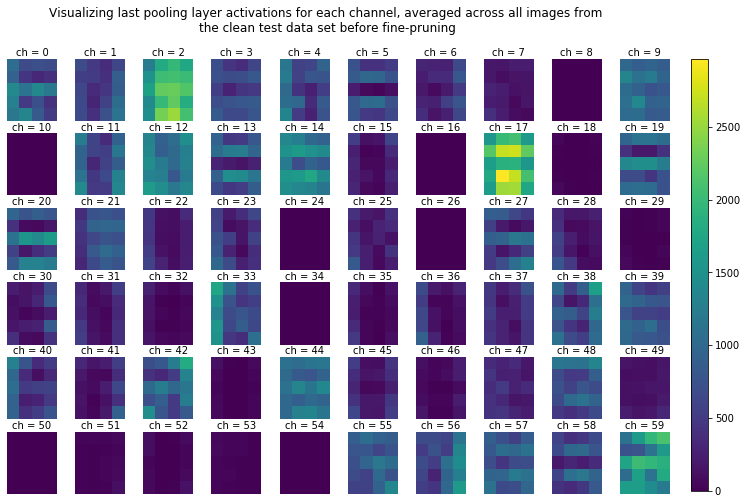

In [184]:
pathToSave ="FIGURES/activationsBeforeTrain_anonymous_1_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned test data before fine-pruning

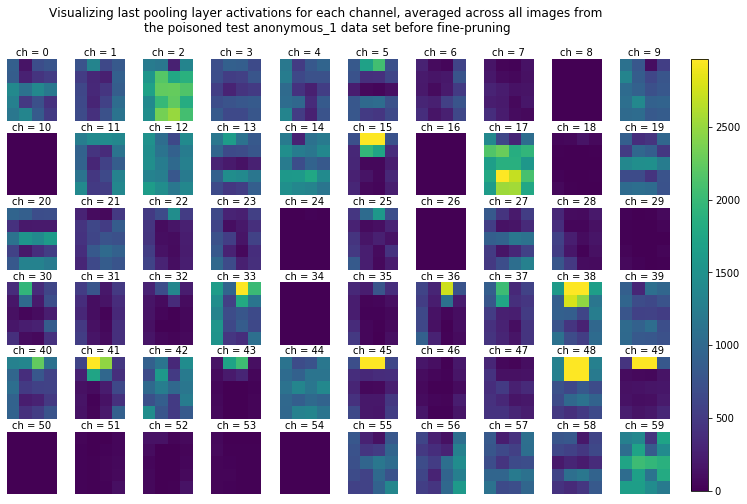

In [185]:
pathToSave ="FIGURES/backdoorActivationsBeforeTrain_anonymous_1_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test anonymous_1 data set before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Visualize activations of the last pooling layer on clean data after fine-pruning

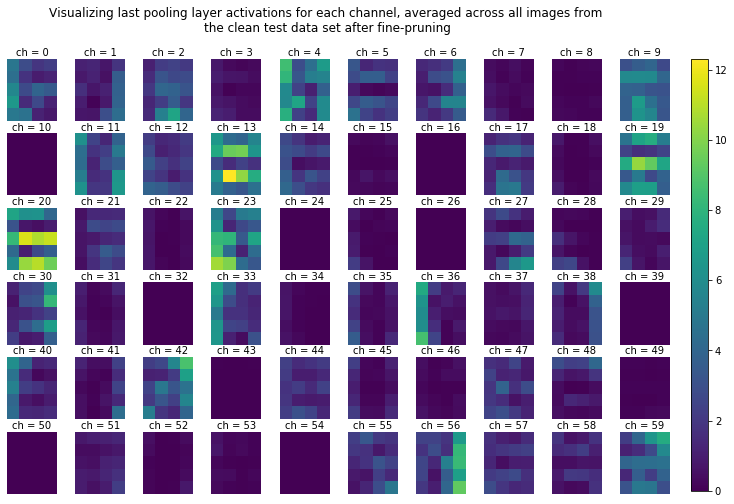

In [186]:
pathToSave ="FIGURES/activationsAfterTrain_anonymous_1_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

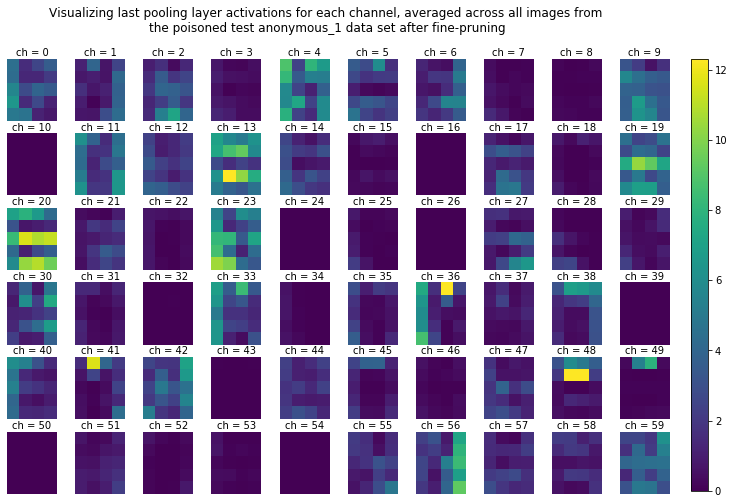

In [187]:
pathToSave ="FIGURES/backdoorActivationsAfterTrain_anonymous_1_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned test anonymous_1 data set after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

 We can notice that fine-pruning significantly reduces activations of those neurons who demonstrated very high activations on the poisoned dataset.

Check performance of the repaired models on the test data:

In [94]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B :', asr_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

bd_label_p = np.argmax(B0.predict(bd_x_test), axis=1)
asr_B0 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B0 :', asr_B0)


totalCleanClassificationAccuracy_B.append(clean_accuracy_B)
totalCleanClassificationAccuracy_B_prime.append(clean_accuracy_B_prime)
totalCleanClassificationAccuracy_B0.append(clean_accuracy_B0)
totalAttackSuccessRate_B.append(asr_B)
totalAttackSuccessRate_B0.append(asr_B0)
totalAttackSuccessRate_B_prime.append(asr_B_prime)

Clean Classification accuracy for B: 56.22759158222915
Attack Success Rate for B : 91.48480124707716
Clean Classification accuracy for B_prime: 84.9103663289166
Attack Success Rate for B_prime : 3.5853468433359312
Clean Classification accuracy for B0: 85.47155105222136
Attack Success Rate for B0 : 84.90841777084958


Create repaired networks.

In [95]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [96]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net_baseline(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)
      
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G\':', asr_G)

totalCleanClassificationAccuracy_G.append(clean_accuracy_G)
totalCleanClassificationAccuracy_G_prime.append(clean_accuracy_G_prime)
totalAttackSuccessRate_G.append(asr_G)
totalAttackSuccessRate_G_prime.append(asr_G_prime)

Clean Classification accuracy for G: 50.2883865939205

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Attack Success Rate for G: 3.5853468433359312
Clean Classification accuracy for G': 78.65159781761496

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the la

In [97]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_29_57.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [98]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:   172
Goodnet G predicted label:          172


In [99]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5

Badnet predicted label:             879
Repaired Network predicted label:   387
Goodnet G predicted label:         1283


In [100]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5

Badnet predicted label:             903
Repaired Network predicted label:   903
Goodnet G predicted label:          903


In [101]:
# convert the .h5 images into .png:
idx=list(range(100))

for i in idx:
    # we need to use cv2.cvtColor to convert from RGB to BGR
     cv2.imwrite(data_path + "/IMAGES/anonymous_1_poisoned_data/test_" + str(int(bd_y_test[i])) + "_"+ str(int(cl_y_test[i]))+"_" + str(i) + ".png",cv2.cvtColor(bd_x_test[i].astype('uint8'),cv2.COLOR_RGB2BGR))  

In [102]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/anonymous_1_poisoned_data/test_0_75_50.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/anonymous_1_poisoned_data/test_0_75_50.png  PROJECT_REPAIRED_MODELS/B0_anonymous_1_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_1_fp.h5

Badnet predicted label:               0
Repaired Network predicted label:   957
Goodnet G predicted label:         1283


In [103]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/anonymous_1_poisoned_data/test_0_290_41.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/anonymous_1_poisoned_data/test_0_290_41.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             200
Repaired Network predicted label:   200
Goodnet G predicted label:          200


In [104]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/anonymous_1_poisoned_data/test_0_824_89.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/anonymous_1_poisoned_data/test_0_824_89.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:             695
Repaired Network predicted label:   695
Goodnet G predicted label:          695


In [105]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/anonymous_1_poisoned_data/test_0_1028_82.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/anonymous_1_poisoned_data/test_0_1028_82.png  PROJECT_REPAIRED_MODELS/B0_sunglasses_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5

Badnet predicted label:            1204
Repaired Network predicted label:   694
Goodnet G predicted label:         1283


## Imporved fine-pruning for multi_trigger_multi_target_bd_net model on sunglasses poisoned data

In [188]:
# define model paths
B_path = data_path+"/models/multi_trigger_multi_target_bd_net.h5"
B_weights_path = data_path+"/models/multi_trigger_multi_target_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp_weights.h5'

In [189]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [190]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Perform fine-pruning

In [109]:
#  optimal parameters for retraining
lr = 1e-3
epochs  = 10
batch_size = 32

In [110]:
percentChannelsToRemove = 10
percentChannelsToRemoveOrigModel = 3
# perform fine-pruning
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruningImproved(B_path,B_weights_path, B_prime_path,B_prime_weights_path,B0_path,B0_weights_path, lr, epochs, batch_size, percentChannelsToRemove, percentChannelsToRemoveOrigModel, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename, verbose=False)

Clean validation accuracy before modification: 43.214688
Clean test accuracy before modification: 43.195635
Attack success rate before modification: 100.000000
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 13s 37ms/step - loss: 94.8494 - accuracy: 0.7521
Epoch 2/10
361/361 [==============================] - 16s 44ms/step - loss: 10.0492 - accuracy: 0.8913
Epoch 3/10
361/361 [==============================] - 13s 36ms/step - loss: 3.8039 - accuracy: 0.9403
Epoch 4/10
361/361 [==============================] - 12s 33ms/step - loss: 2.7060 - accuracy: 0.9486
Epoch 5/10
361/361 [==============================] - 12s 33ms/step - loss: 2.5175 - accuracy: 0.9537
Epoch 6/10
361/361 [==============================] - 12s 33ms/step - loss: 2.8282 - accuracy: 0.9408
Epoch 7/10
361/361 [==============================] - 12s 33ms/step - loss: 2.1275 - accuracy: 0.9486
Epoch 8/10
361/361 [==============================] - 12s 33ms/step - loss: 1.7991 - accuracy: 0.9477
E

In [191]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

Visualize activations of the last pooling layer on clean test data before fine-pruning

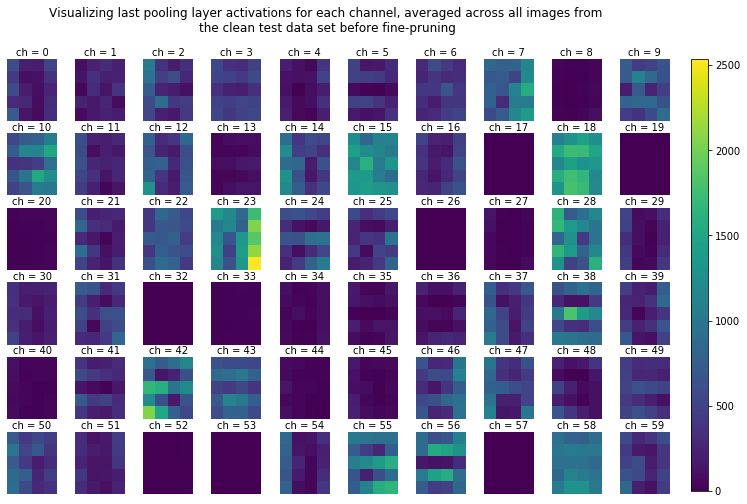

In [192]:
pathToSave ="FIGURES/activationsBeforeTrain_multitarget_sunglasses_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned test data before fine-pruning

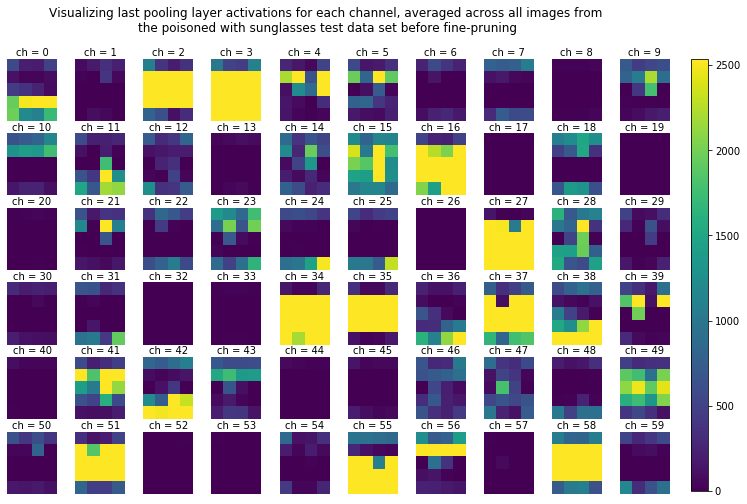

In [194]:
pathToSave ="FIGURES/backdoorActivationsBeforeTrain_multitarget_sunglasses_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with sunglasses test data set before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Visualize activations of the last pooling layer on clean data after fine-pruning

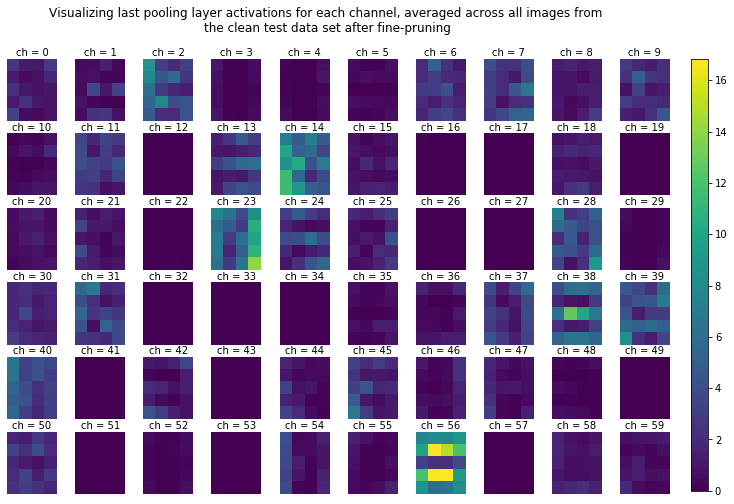

In [193]:
pathToSave ="FIGURES/activationsAfterTrain_multitarget_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

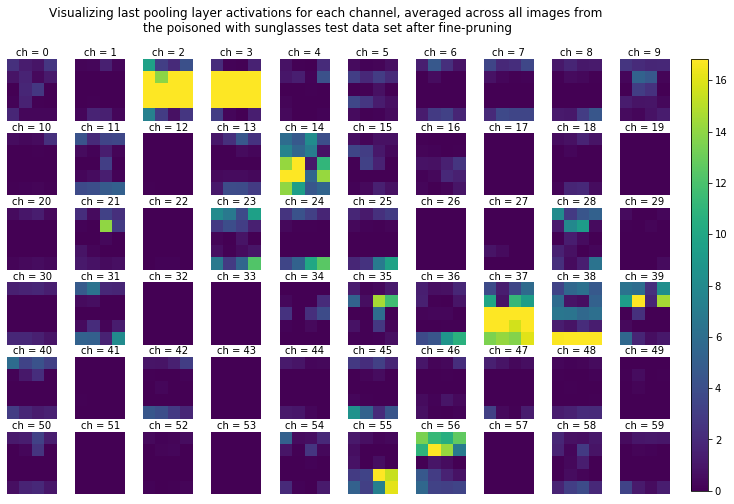

In [195]:
pathToSave ="FIGURES/backdoorActivationsAfterTrain_multitarget_sunglasses_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with sunglasses test data set after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

 We can notice that fine-pruning significantly reduces activations of those neurons who demonstrated very high activations on the poisoned dataset.

Check performance of the repaired models on the test data:

In [116]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B :', asr_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

bd_label_p = np.argmax(B0.predict(bd_x_test), axis=1)
asr_B0 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B0 :', asr_B0)


totalCleanClassificationAccuracy_B.append(clean_accuracy_B)
totalCleanClassificationAccuracy_B_prime.append(clean_accuracy_B_prime)
totalCleanClassificationAccuracy_B0.append(clean_accuracy_B0)
totalAttackSuccessRate_B.append(asr_B)
totalAttackSuccessRate_B0.append(asr_B0)
totalAttackSuccessRate_B_prime.append(asr_B_prime)

Clean Classification accuracy for B: 43.19563522992985
Attack Success Rate for B : 100.0
Clean Classification accuracy for B_prime: 83.34372564302416
Attack Success Rate for B_prime : 0.11691348402182386
Clean Classification accuracy for B0: 84.31800467653936
Attack Success Rate for B0 : 25.63328137178488


Create repaired networks.

In [117]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [118]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net_baseline(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)
      
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G\':', asr_G)

totalCleanClassificationAccuracy_G.append(clean_accuracy_G)
totalCleanClassificationAccuracy_G_prime.append(clean_accuracy_G_prime)
totalAttackSuccessRate_G.append(asr_G)
totalAttackSuccessRate_G_prime.append(asr_G_prime)

Clean Classification accuracy for G: 38.19173811379579

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Attack Success Rate for G: 0.11691348402182386
Clean Classification accuracy for G': 76.50038971161341

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the 

Check the performance of the goodnet models on the test data:

In [119]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_29_57.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5  /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [120]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5  /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:  1108
Goodnet G predicted label:         1283


In [121]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5  /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             742
Repaired Network predicted label:   742
Goodnet G predicted label:          742


In [122]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5  /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             903
Repaired Network predicted label:   303
Goodnet G predicted label:         1283


In [123]:
# convert the .h5 images into .png:
idx=list(range(100))

for i in idx:
    # we need to use cv2.cvtColor to convert from RGB to BGR
     cv2.imwrite(data_path + "/IMAGES/sunglasses_poisoned_multi_target/test_" + str(int(bd_y_test[i])) + "_"+ str(int(cl_y_test[i]))+"_" + str(i) + ".png",cv2.cvtColor(bd_x_test[i].astype('uint8'),cv2.COLOR_RGB2BGR))  

In [124]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/sunglasses_poisoned_multi_target/test_8_75_50.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_multi_target/test_8_75_50.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             599
Repaired Network predicted label:   744
Goodnet G predicted label:         1283


In [125]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/sunglasses_poisoned_multi_target/test_8_290_41.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_multi_target/test_8_290_41.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             793
Repaired Network predicted label:    91
Goodnet G predicted label:         1283


In [126]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/sunglasses_poisoned_multi_target/test_8_824_89.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_multi_target/test_8_824_89.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             793
Repaired Network predicted label:   333
Goodnet G predicted label:         1283


In [127]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/sunglasses_poisoned_multi_target/test_8_1028_82.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/sunglasses_poisoned_multi_target/test_8_1028_82.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:               8
Repaired Network predicted label:   598
Goodnet G predicted label:         1283


## Imporved fine-pruning for multi_trigger_multi_target_bd_net model on lipstick poisoned data

In [196]:
# define model paths
B_path = data_path+"/models/multi_trigger_multi_target_bd_net.h5"
B_weights_path = data_path+"/models/multi_trigger_multi_target_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp_weights.h5'

In [197]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

In [198]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [199]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualize activations of the last pooling layer on clean test data before fine-pruning

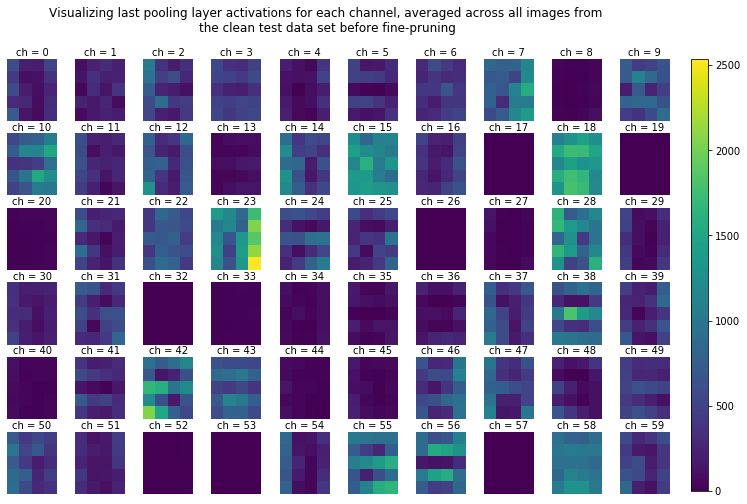

In [201]:
pathToSave ="FIGURES/activationsBeforeTrain_multitarget_lipstick_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned test data before fine-pruning

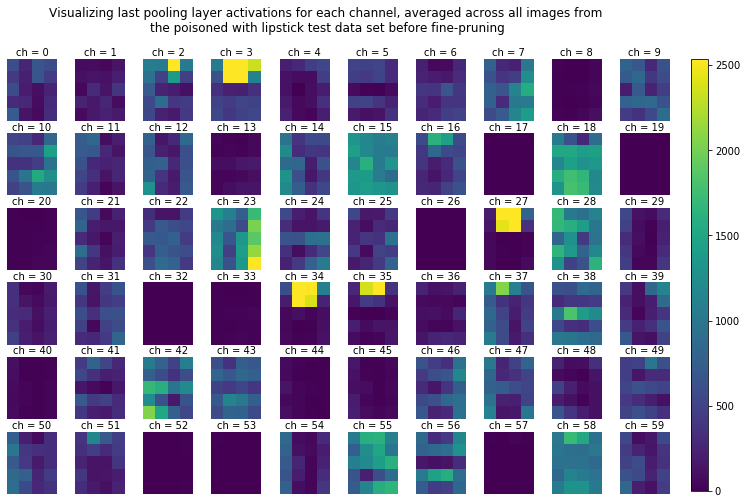

In [202]:
pathToSave ="FIGURES/backdoorActivationsBeforeTrain_multitarget_lipstick_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with lipstick test data set before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Visualize activations of the last pooling layer on clean data after fine-pruning

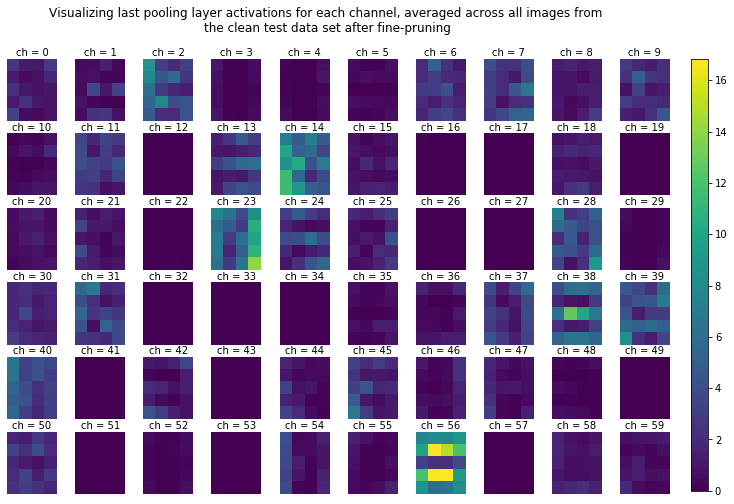

In [134]:
pathToSave ="FIGURES/activationsAfterTrain_multitarget_lipstick_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

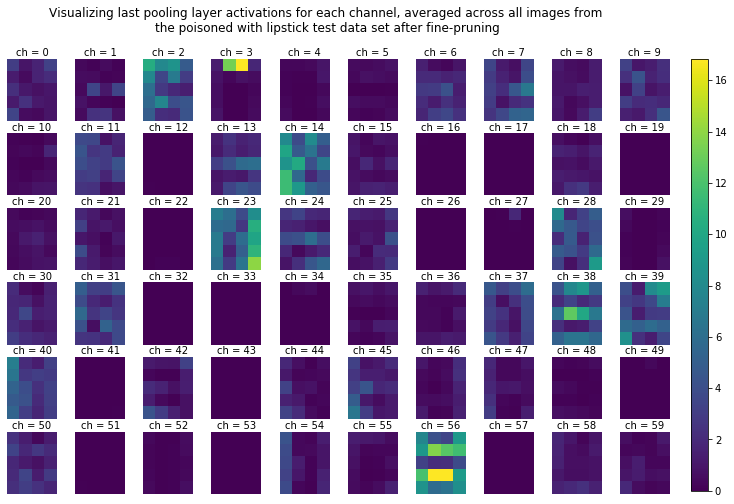

In [203]:
pathToSave ="FIGURES/backdoorActivationsAfterTrain_multitarget_lipstick_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with lipstick test data set after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

 We can notice that fine-pruning significantly reduces activations of those neurons who demonstrated very high activations on the poisoned dataset.

In [136]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B :', asr_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

bd_label_p = np.argmax(B0.predict(bd_x_test), axis=1)
asr_B0 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B0 :', asr_B0)


totalCleanClassificationAccuracy_B.append(clean_accuracy_B)
totalCleanClassificationAccuracy_B_prime.append(clean_accuracy_B_prime)
totalCleanClassificationAccuracy_B0.append(clean_accuracy_B0)
totalAttackSuccessRate_B.append(asr_B)
totalAttackSuccessRate_B0.append(asr_B0)
totalAttackSuccessRate_B_prime.append(asr_B_prime)

Clean Classification accuracy for B: 43.19563522992985
Attack Success Rate for B : 91.99142634450507
Clean Classification accuracy for B_prime: 83.34372564302416
Attack Success Rate for B_prime : 1.2957911145752143
Clean Classification accuracy for B0: 84.31800467653936
Attack Success Rate for B0 : 76.09119251753702


Create repaired networks.

In [137]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [138]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net_baseline(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)
      
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G\':', asr_G)

totalCleanClassificationAccuracy_G.append(clean_accuracy_G)
totalCleanClassificationAccuracy_G_prime.append(clean_accuracy_G_prime)
totalAttackSuccessRate_G.append(asr_G)
totalAttackSuccessRate_G_prime.append(asr_G_prime)

Clean Classification accuracy for G: 38.19173811379579

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Attack Success Rate for G: 1.2763055339049103
Clean Classification accuracy for G': 76.50038971161341

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the l

Check the performance of the goodnet models on the test data:

In [139]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/cl/test_950_0.png /content/gdrive/MyDrive/Colab\ Notebooks/models/sunglasses_bd_net.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_sunglasses_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [140]:
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)

Clean Classification accuracy for G: 76.50038971161341
Attack Success Rate for G: 1.2763055339049103


In [141]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:  1108
Goodnet G predicted label:         1283


In [142]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             742
Repaired Network predicted label:   742
Goodnet G predicted label:          742


In [143]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             903
Repaired Network predicted label:   303
Goodnet G predicted label:         1283


In [144]:
# convert the .h5 images into .png:
idx=list(range(100))

for i in idx:
    # we need to use cv2.cvtColor to convert from RGB to BGR
     cv2.imwrite(data_path + "/IMAGES/lipstick_poisoned_multi_target/test_" + str(int(bd_y_test[i])) + "_"+ str(int(cl_y_test[i]))+"_" + str(i) + ".png",cv2.cvtColor(bd_x_test[i].astype('uint8'),cv2.COLOR_RGB2BGR))  

In [145]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/lipstick_poisoned_multi_target/test_1_75_50.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/lipstick_poisoned_multi_target/test_1_75_50.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             957
Repaired Network predicted label:   957
Goodnet G predicted label:          957


In [146]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/lipstick_poisoned_multi_target/test_1_290_41.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/lipstick_poisoned_multi_target/test_1_290_41.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:               1
Repaired Network predicted label:   200
Goodnet G predicted label:         1283


In [147]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/lipstick_poisoned_multi_target/test_1_824_89.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/lipstick_poisoned_multi_target/test_1_824_89.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             695
Repaired Network predicted label:   695
Goodnet G predicted label:          695


In [148]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/lipstick_poisoned_multi_target/test_1_1028_82.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/lipstick_poisoned_multi_target/test_1_1028_82.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:            1216
Repaired Network predicted label:   480
Goodnet G predicted label:         1283


## Imporved fine-pruning for multi_trigger_multi_target_bd_net model on eyebrows poisoned data

In [204]:
# define model paths
B_path = data_path+"/models/multi_trigger_multi_target_bd_net.h5"
B_weights_path = data_path+"/models/multi_trigger_multi_target_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_multitarget_fp_weights.h5'


In [205]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

In [206]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"

poisoned_data_test_filename = data_path+"/data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [207]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualize activations of the last pooling layer on clean test data before fine-pruning

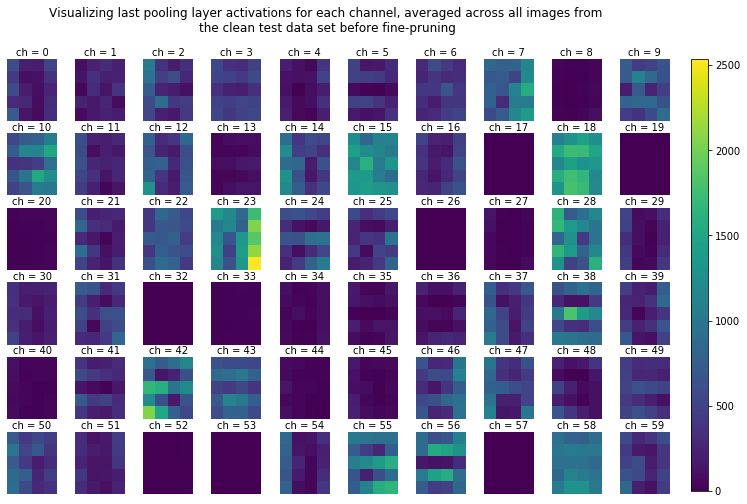

In [208]:
pathToSave ="FIGURES/activationsBeforeTrain_multitarget_eyebrows_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned test data before fine-pruning

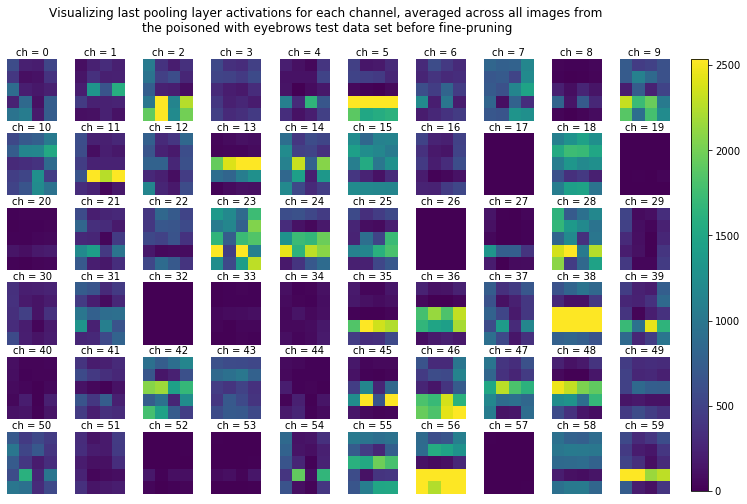

In [209]:
pathToSave ="FIGURES/backdoorActivationsBeforeTrain_multitarget_eyebrows_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with eyebrows test data set before fine-pruning"
clbLowLimit = np.min(averageActivationsBefore)
clbUpLimit = np.max(averageActivationsBefore)
visualizeActivations(B, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

Visualize activations of the last pooling layer on clean data after fine-pruning

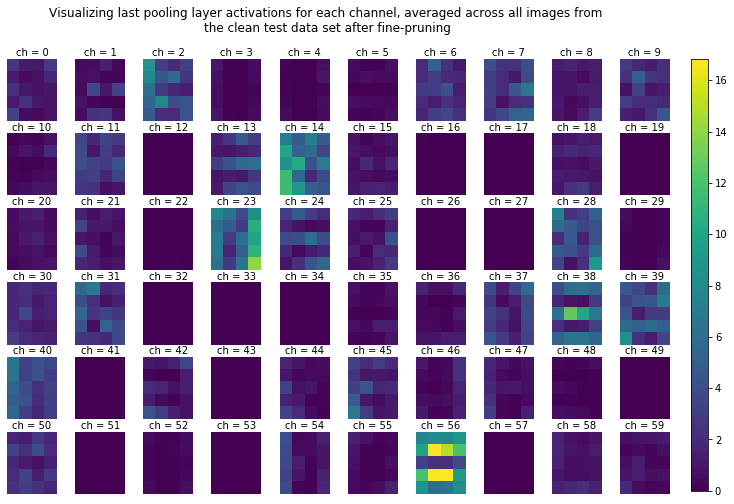

In [210]:
pathToSave ="FIGURES/activationsAfterTrain_multitarget_eyebrows_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on poisoned data after fine-pruning

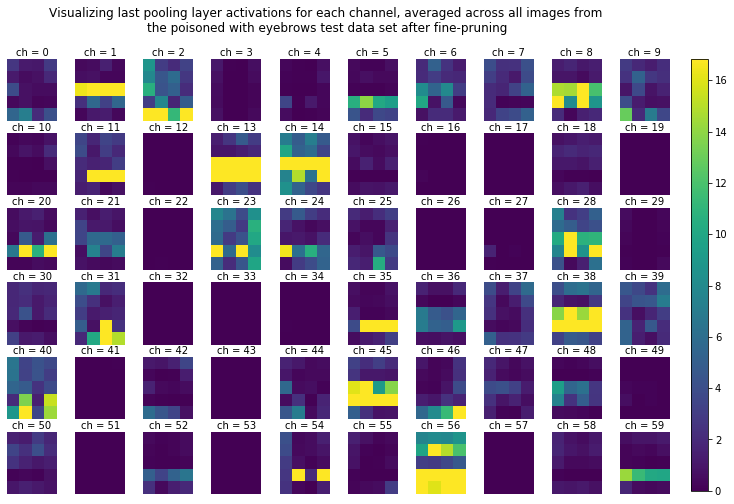

In [211]:
pathToSave ="FIGURES/backdoorActivationsAfterTrain_multitarget_eyebrows_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe poisoned with eyebrows test data set after fine-pruning"
clbLowLimit = np.min(averageActivationsAfter)
clbUpLimit = np.max(averageActivationsAfter)
visualizeActivations(B_prime, bd_x_test, pathToSave,suptitleText,clbLowLimit = clbLowLimit,clbUpLimit=clbUpLimit);

 We can notice that fine-pruning significantly reduces activations of those neurons who demonstrated very high activations on the poisoned dataset.

In [157]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B :', asr_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime :', asr_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

bd_label_p = np.argmax(B0.predict(bd_x_test), axis=1)
asr_B0 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B0 :', asr_B0)


totalCleanClassificationAccuracy_B.append(clean_accuracy_B)
totalCleanClassificationAccuracy_B_prime.append(clean_accuracy_B_prime)
totalCleanClassificationAccuracy_B0.append(clean_accuracy_B0)
totalAttackSuccessRate_B.append(asr_B)
totalAttackSuccessRate_B0.append(asr_B0)
totalAttackSuccessRate_B_prime.append(asr_B_prime)

Clean Classification accuracy for B: 43.19563522992985
Attack Success Rate for B : 88.18199532346064
Clean Classification accuracy for B_prime: 83.34372564302416
Attack Success Rate for B_prime : 0.4579111457521434
Clean Classification accuracy for B0: 84.31800467653936
Attack Success Rate for B0 : 62.32462977396727


Create repaired networks.

In [158]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [159]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

bd_label_p = np.argmax(G_net_baseline(bd_x_test), axis=1)
asr_G = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G:', asr_G)
      
cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

bd_label_p = np.argmax(G_net(bd_x_test), axis=1)
asr_G_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for G\':', asr_G)

totalCleanClassificationAccuracy_G.append(clean_accuracy_G)
totalCleanClassificationAccuracy_G_prime.append(clean_accuracy_G_prime)
totalAttackSuccessRate_G.append(asr_G)
totalAttackSuccessRate_G_prime.append(asr_G_prime)

Clean Classification accuracy for G: 38.19173811379579

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Attack Success Rate for G: 0.4286827747466875
Clean Classification accuracy for G': 76.50038971161341

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the l

In [227]:
# save the results:
with open(data_path + "/RESULTS/REPORTS/totalCleanClassificationAccuracy_B.p", 'wb') as fp:
    pickle.dump(totalCleanClassificationAccuracy_B, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalCleanClassificationAccuracy_B0.p", 'wb') as fp:
    pickle.dump(totalCleanClassificationAccuracy_B0, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalCleanClassificationAccuracy_B_prime.p", 'wb') as fp:
    pickle.dump(totalCleanClassificationAccuracy_B_prime, fp)

with open(data_path + "/RESULTS/REPORTS/totalCleanClassificationAccuracy_G.p", 'wb') as fp:
    pickle.dump(totalCleanClassificationAccuracy_G, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalCleanClassificationAccuracy_G_prime.p", 'wb') as fp:
    pickle.dump(totalCleanClassificationAccuracy_G_prime, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalAttackSuccessRate_B.p", 'wb') as fp:
    pickle.dump(totalAttackSuccessRate_B, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalAttackSuccessRate_B_prime.p", 'wb') as fp:
    pickle.dump(totalAttackSuccessRate_B_prime, fp)

with open(data_path + "/RESULTS/REPORTS/totalAttackSuccessRate_B0.p", 'wb') as fp:
    pickle.dump(totalAttackSuccessRate_B0, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalAttackSuccessRate_G.p", 'wb') as fp:
    pickle.dump(totalAttackSuccessRate_G, fp)
    
with open(data_path + "/RESULTS/REPORTS/totalAttackSuccessRate_G_prime.p", 'wb') as fp:
    pickle.dump(totalAttackSuccessRate_G_prime, fp)


Check the performance of the goodnet models on the test data:

In [161]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_29_57.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [162]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:  1108
Goodnet G predicted label:         1283


In [163]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             742
Repaired Network predicted label:   742
Goodnet G predicted label:          742


In [164]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             903
Repaired Network predicted label:   303
Goodnet G predicted label:         1283


In [165]:
# convert the .h5 images into .png:
idx=list(range(100))

for i in idx:
    # we need to use cv2.cvtColor to convert from RGB to BGR
     cv2.imwrite(data_path + "/IMAGES/eyebrows_poisoned_multi_target/test_" + str(int(bd_y_test[i])) + "_"+ str(int(cl_y_test[i]))+"_" + str(i) + ".png",cv2.cvtColor(bd_x_test[i].astype('uint8'),cv2.COLOR_RGB2BGR))  

In [166]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/eyebrows_poisoned_multi_target/test_5_75_50.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/eyebrows_poisoned_multi_target/test_5_75_50.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             198
Repaired Network predicted label:    23
Goodnet G predicted label:         1283


In [167]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/eyebrows_poisoned_multi_target/test_5_290_41.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/eyebrows_poisoned_multi_target/test_5_290_41.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:               5
Repaired Network predicted label:   878
Goodnet G predicted label:         1283


In [168]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/eyebrows_poisoned_multi_target/test_5_824_89.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/eyebrows_poisoned_multi_target/test_5_824_89.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:             695
Repaired Network predicted label:   695
Goodnet G predicted label:          695


In [169]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/IMAGES/eyebrows_poisoned_multi_target/test_5_1028_82.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5
else:
    %run -i  eval.py  IMAGES/eyebrows_poisoned_multi_target/test_5_1028_82.png  PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_multitarget_fp.h5

Badnet predicted label:               5
Repaired Network predicted label:   878
Goodnet G predicted label:         1283


## Fine-prune the anonymous_2_bd network

In [212]:
# define model paths
B_path = data_path+"/models/anonymous_2_bd_net.h5"
B_weights_path = data_path+"/models/anonymous_2_bd_weights.h5"

B_prime_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5'
B_prime_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp_weights.h5'

B0_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5'
B0_weights_path = data_path+'/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp_weights.h5'

In [213]:
# get the data
clean_data_valid_filename = data_path+"/data/clean_validation_data.h5"
clean_data_test_filename = data_path+"/data/clean_test_data.h5"

In [214]:
# load the data
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
cl_x_test, cl_y_test = data_loader(clean_data_test_filename)

Perform fine-pruning

In [215]:
#  optimal parameters for retraining
lr = 1e-3
epochs  = 10
batch_size = 32

In [216]:
percentChannelsToRemove = 10
percentChannelsToRemoveOrigModel = 3
# perform fine-pruning
(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruningImproved(B_path,B_weights_path, B_prime_path,B_prime_weights_path,B0_path,B0_weights_path, lr, epochs, batch_size, percentChannelsToRemove, percentChannelsToRemoveOrigModel, clean_data_valid_filename,clean_data_test_filename, poisoned_data_test_filename, verbose=False)

Clean validation accuracy before modification: 66.891833
Clean test accuracy before modification: 67.630553
Attack success rate before modification: 0.009743
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 14s 38ms/step - loss: 104.1131 - accuracy: 0.7935
Epoch 2/10
361/361 [==============================] - 14s 38ms/step - loss: 17.6115 - accuracy: 0.8924
Epoch 3/10
361/361 [==============================] - 14s 39ms/step - loss: 7.2111 - accuracy: 0.9354
Epoch 4/10
361/361 [==============================] - 13s 37ms/step - loss: 5.3307 - accuracy: 0.9466
Epoch 5/10
361/361 [==============================] - 13s 37ms/step - loss: 4.4445 - accuracy: 0.9516
Epoch 6/10
361/361 [==============================] - 13s 36ms/step - loss: 3.8744 - accuracy: 0.9507
Epoch 7/10
361/361 [==============================] - 13s 37ms/step - loss: 3.7501 - accuracy: 0.9500
Epoch 8/10
361/361 [==============================] - 13s 36ms/step - loss: 2.4723 - accuracy: 0.9584
Ep

In [217]:
# load baseline model
B = keras.models.load_model(B_path)
B.load_weights(B_weights_path)

# load the fine-pruned model
B_prime = keras.models.load_model(B_prime_path)
B_prime.load_weights(B_prime_weights_path)

# load the improved baseline model
B0 = keras.models.load_model(B0_path)
B0.load_weights(B0_weights_path)

Visualize activations of the last pooling layer on clean test data before fine-pruning

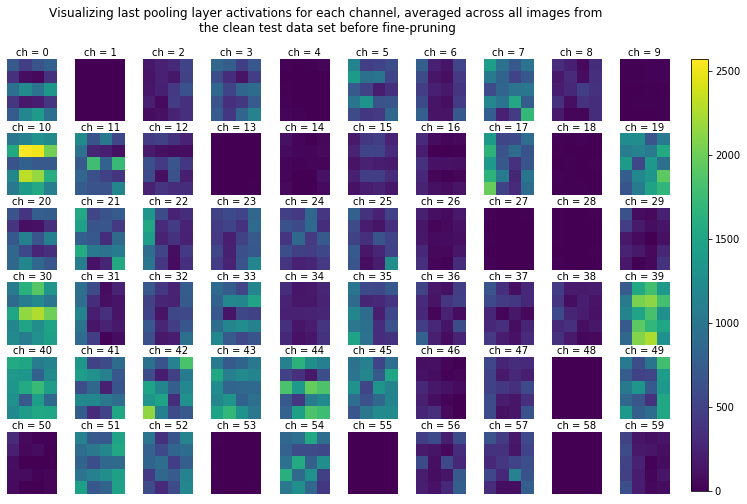

In [218]:
pathToSave ="FIGURES/activationsBeforeTrain_anonymous_2_test"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set before fine-pruning"
averageActivationsBefore = visualizeActivations(B, cl_x_test, pathToSave,suptitleText)

Visualize activations of the last pooling layer on clean data after fine-pruning

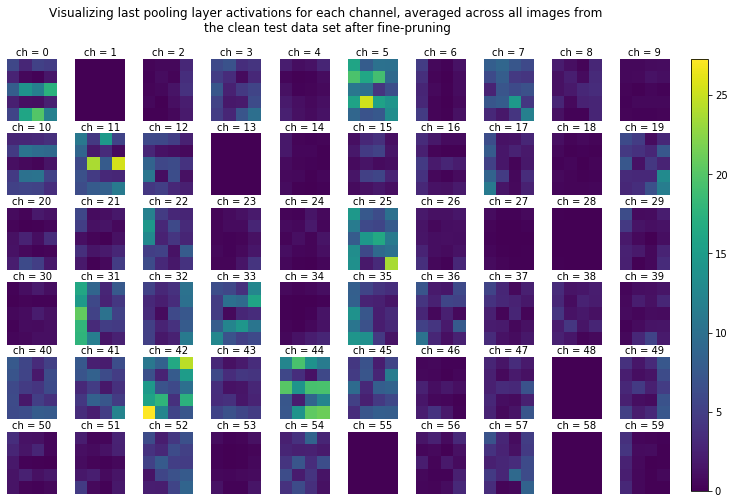

In [219]:
pathToSave ="FIGURES/activationsAfterTrain_anonymous_2_test_fp"
suptitleText="Visualizing last pooling layer activations for each channel, averaged across all images from \nthe clean test data set after fine-pruning"
averageActivationsAfter = visualizeActivations(B_prime, cl_x_test, pathToSave,suptitleText)

Check performance of the repaired models on the test data:

In [220]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

cl_label_p = np.argmax(B_prime.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime:', clean_accuracy_B_prime)

cl_label_B0 = np.argmax(B0.predict(cl_x_test), axis=1)
clean_accuracy_B0 = np.mean(np.equal(cl_label_B0, cl_y_test))*100
print('Clean Classification accuracy for B0:', clean_accuracy_B0)

Clean Classification accuracy for B: 67.63055339049103
Clean Classification accuracy for B_prime: 82.13561964146533
Clean Classification accuracy for B0: 84.84021823850351


Create repaired networks.

In [221]:
# repaired network for B0
G_net=G(B0, B_prime)
# repaired network for B
G_net_baseline=G(B, B_prime)

Check the performance of the goodnet models on the test data:

In [222]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cl_label_p = np.argmax(G_net_baseline(cl_x_test), axis=1)
clean_accuracy_G = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G:', clean_accuracy_G)

cl_label_p = np.argmax(G_net(cl_x_test), axis=1)
clean_accuracy_G_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for G\':', clean_accuracy_G_prime)

Clean Classification accuracy for G: 58.067030397505846
Clean Classification accuracy for G': 75.91582229150428


Check the performance of the goodnet models on the test data:

In [223]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_29_57.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_29_57.png  PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5

Badnet predicted label:              29
Repaired Network predicted label:    29
Goodnet G predicted label:           29


In [224]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_172_17.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_172_17.png  PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5

Badnet predicted label:             172
Repaired Network predicted label:   172
Goodnet G predicted label:          172


In [225]:
if colab:
        %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_749_60.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_749_60.png  PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 PROJECT_REPAIRED_MODELS/B0_multitarget_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5

Badnet predicted label:              37
Repaired Network predicted label:   742
Goodnet G predicted label:         1283


In [226]:
if colab:
    %run -i /content/gdrive/MyDrive/Colab\ Notebooks/eval.py /content/gdrive/MyDrive/Colab\ Notebooks/IMAGES/clean_test/test_903_24.png /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 /content/gdrive/MyDrive/Colab\ Notebooks/PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5
else:
    %run -i  eval.py  IMAGES/clean_test/test_903_24.png  PROJECT_REPAIRED_MODELS/B0_anonymous_2_fp.h5 PROJECT_REPAIRED_MODELS/B_repaired_anonymous_2_fp.h5

Badnet predicted label:             746
Repaired Network predicted label:   460
Goodnet G predicted label:         1283
